# Import Libraries

In [1]:
!pip install xgboost

In [2]:
!pip install --user imbalanced-learn

In [1]:
#Untuk Explore dan Preprocessing Data
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import external
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#Untuk Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import joblib

#Untuk Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#Untuk Evaluasi Model
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, RocCurveDisplay

#Untuk Interpretasi Model
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Module XGBoost Approximator

## Utils

In [2]:
"""
This module contains several functions that are used in various stages of the process
"""
import numpy as np
from sklearn.metrics import roc_curve, auc
import xgboost as xg
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import random

RANDOM_SEED = 1

def softmax(x):
    """
    This function is useful for converting the aggregated results come from the different trees into class probabilities
    :param x: Numpy k-dimensional array
    :return: Softmax of X
    """
    return np.array([np.exp(x)/np.sum(np.exp(x))])

def get_auc(test_y,y_score):
    """

    :param test_y: Labels
    :param y_score: probabilities of labels
    :return: ROC AUC score
    """
    np.random.seed(RANDOM_SEED)
    classes=[i for i in range(y_score.shape[1])]
    y_test_binarize=np.array([[1 if i ==c else 0 for c in classes] for i in test_y])
    fpr, tpr, _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
    return auc(fpr, tpr)

def train_decision_tree(train,feature_cols,label_col):
    """
    This function gets a dataframe as an input and optimizes a decision tree to the data

    :param train: Pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :return: Trained sklearn decision tree
    """
    np.random.seed(RANDOM_SEED)
    parameters = {'criterion': ['entropy', 'gini'],
                  'max_depth': [3, 5, 10, 20, 50],
                  'min_samples_leaf': [1, 2, 5, 10]}
    model = DecisionTreeClassifier()
    clfGS = GridSearchCV(model, parameters, cv=3)
    clfGS.fit(train[feature_cols].values, train[label_col])
    return clfGS.best_estimator_



def train_rf_model(train,feature_cols,label_col):
    """
        This function gets a dataframe as an input and optimizes a random forest classifier to the data

        :param train: Pandas dataframe
        :param feature_cols: feature column names
        :param label_col: label column name
        :return: Trained random forest classifier
        """
    np.random.seed(RANDOM_SEED)
    parameters = {'n_estimators':[50,100],
                  'criterion': ['entropy'],
                  'min_samples_leaf': [1, 10, 100],
                  'max_features':['auto','log2']}
    model = RandomForestClassifier()
    clfGS = GridSearchCV(model, parameters, cv=3)
    clfGS.fit(train[feature_cols].values, train[label_col])
    return clfGS.best_estimator_

def train_xgb_classifier(train,feature_cols,label_col,xgb_params):
    """
    Train an XGBoost to the input dataframe

    :param train: pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :param xgb_params: Dict of XGBoost parameters
    :return: label column namened XGboost
    """
    np.random.seed(RANDOM_SEED)
    tuning_params = {'colsample_bytree': [0.3,0.5,0.9],
                  'learning_rate': [0.01,0.1],
                  'max_depth': [2,5,10],
                  'alpha': [1,10],
                     'n_estimators':[50,100]}
    if train[label_col].nunique() > 2:
        xgb_params['objective'] = "multi:softprob"
    else:
        xgb_params['objective'] = "binary:logitraw"
    model = xg.XGBClassifier(xgb_params)
    clfGS = GridSearchCV(model, tuning_params, cv=3)
    clfGS.fit(train[feature_cols], train[label_col])
    return clfGS.best_estimator_

def decision_tree_instance_depth(inst, dt):
    """

    :param inst: Instance to be inferenced - numpy vector
    :param dt: sklearn decision tree
    :return: The depth of the leaf that corresponds the instance
    """
    indx = 0
    depth = 0
    # epsilon: thresholds may be shifted by a very small floating points. For example: x1 <= 2.6 may become x1 <= 2.5999999
    # and then x1 = 2.6 won't be captured
    epsilon = 0.0000001
    t = dt.tree_
    while t.feature[indx] >= 0:
        if inst[t.feature[indx]] <= t.threshold[indx] + epsilon:
            indx = t.children_left[indx]
        else:
            indx = t.children_right[indx]
        depth += 1
    return  depth

def decision_tree_depths(test,feature_cols,dt):
    """
    This function is used for calculatingg the prediction depths of each instance that were inferenced by the input
    decision tree

    :param test: Pandas dataframe
    :param feature_cols: feature column names
    :param dt: decision tree
    :return: the depths of leaves that were assigned to each instance
    """
    X = test[feature_cols].values
    return [decision_tree_instance_depth(inst,dt) for inst in X]

#The following are not used:

def train_xgb_classifier2(train,feature_cols,label_col,xgb_params):
    """
    Train an XGBoost to the input dataframe

    :param train: pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :param xgb_params: Dict of XGBoost parameters
    :return: label column namened XGboost
    """
    if train[label_col].nunique() > 2:
        obj = "multi:softprob"
    else:
        obj = "binary:logitraw"
    xgb_model = xg.XGBClassifier(**xgb_params)
    xgb_model.fit(train[feature_cols], train[label_col])
    return  xgb_model

def ensemble_prediction_depth(X, rf):
    depths = []
    for inst in X:
        depths.append(np.sum([tree_prediction_depth(inst,base_model.tree_) for base_model in rf.estimators_]))
    return depths

def tree_prediction_depth(inst, t):
    indx = 0
    depth = 0
    epsilon = 0.0000001
    # epsilon: thresholds may be shifted by a very small floating points. For example: x1 <= 2.6 may become x1 <= 2.5999999
    # and then x1 = 2.6 won't be captured
    while t.feature[indx] >= 0:
        if inst[t.feature[indx]] <= t.threshold[indx] + epsilon:
            indx = t.children_left[indx]
        else:
            indx = t.children_right[indx]
        depth += 1
    return depth

def get_features_statistics(data):
    min_values = {col:min(data[col]) for col in data.columns}
    max_values = {col: max(data[col]) for col in data.columns}
    mean_values = {col: np.mean(data[col]) for col in data.columns}
    return min_values, max_values, mean_values

##Conjunction

In [3]:
"""
This module contains the conjunction class

"""
import numpy as np

class Conjunction():
    """
    A conjunction is a combination of feature bounds mapped into a class probability vector
    """
    def __init__(self,feature_names,label_names,leaf_index=None,label_probas=None):
        """
        :param feature_names: list of strings. Also determine the dimensionality
        :param label_names: list of labels. Determines the number of labels too
        :param leaf_index: This feature is optional. Can be relevant if we'd like to document the leaves that were used from the input forest
        :param label_probas: also optional. Relevant if we'd like to determine the class probabilities within the constructor
        """
        self.feature_names = feature_names
        self.number_of_features = len(feature_names)
        self.label_names = label_names

        # upper and lower bounds of the feature for each rule
        self.features_upper = [np.inf] * len(feature_names)
        self.features_lower = [-np.inf] * len(feature_names)

        self.label_probas = np.array(label_probas)
        self.leaf_index = leaf_index

        #The following dict is used for excluding irrelevant merges of different dummy variables that come from the same categorical feature
        self.categorical_features_dict={}

    def addCondition(self, feature, threshold, bound):
        """
        This method adds a condition to the conjunction if relevant (rule isn't already contained in the conjunction)

        :param feature: relevant feature
        :param threshold: upper\lower bound
        :param bound: bound direction

        """
        #Check if the rule isn't already contained in the conjunction
        if bound == 'lower':
            if self.features_lower[feature] < threshold:
                self.features_lower[feature] = threshold
        else:
            if self.features_upper[feature] > threshold:
                self.features_upper[feature] = threshold

        #Address categorical features:
        if '=' in self.feature_names[feature] and threshold >= 1 and bound == 'lower':
            splitted = self.feature_names[feature].split('=')
            self.categorical_features_dict[splitted[0]] = splitted[1]

    def isContradict(self, other_conjunction):
        """
        :param other_conjunction: conjunction object
        :return: True if other and self have at least one contradiction, otherwise False
        """

        #Check upper and lower bounds contradiction
        for i in range(self.number_of_features):
            if self.features_upper[i] <= other_conjunction.features_lower[i] or self.features_lower[i] >=  other_conjunction.features_upper[i]:
                return True

        # check for categorical features contradiction
        for feature in self.feature_names:
            if feature in self.categorical_features_dict and feature in other_conjunction.categorical_features_dict:
                if self.categorical_features_dict[feature] != other_conjunction.categorical_features_dict[feature]:
                    return True

    def merge(self, other):
        """
        :param other: conjunction
        :return: new_conjunction - a merge of the self conjunction with other
        """
        new_conjunction = Conjunction(self.feature_names,self.label_names,
                                      self.leaf_index+other.leaf_index,self.label_probas+other.label_probas)
        new_conjunction.features_upper = [min(i,j) for i,j in zip(self.features_upper,other.features_upper)]
        new_conjunction.features_lower = [max(i, j) for i, j in zip(self.features_lower, other.features_lower)]
        new_conjunction.categorical_features_dict = self.categorical_features_dict
        new_conjunction.categorical_features_dict.update(other.categorical_features_dict)
        return new_conjunction

    def containsInstance(self,inst):
        """
        Checks whether the input instance falls under the conjunction

        :param inst:
        :return: True if
        """
        for i, lower, upper in zip(range(len(inst)), self.features_lower, self.features_upper):
            if inst[i] >= upper or inst[i] < lower:
                return False
        return True

    def has_low_interval(self,lowest_intervals):
        for lower,upper,interval in zip(self.features_lower,self.features_upper,lowest_intervals):
            if upper-lower<interval:
                return True
        return False

    def predict_probas(self):
        """
        :return: softmax of the result vector
        """

        return softmax(self.label_probas)

    def toString(self):
        """
        This function creates a string representation of the conjunction (only for demonstration purposes)
        """
        s = ""
        #save lower bounds
        for feature, threshold in enumerate(self.features_lower):
            if threshold != (-np.inf):
                s +=  self.feature_names[feature] + ' >= ' + str(np.round(threshold,3)) + ", "
        #save upper bounds
        for feature, threshold in enumerate(self.features_upper):
            if threshold != np.inf:
                s +=  self.feature_names[feature] + ' < ' + str(np.round(threshold,3)) + ", "
        #save labels
        s += 'labels: ['
        s+=str(self.label_probas)
        s += ']'
        return s

    #From here on everything is still tested
    def get_data_point(self, min_values, max_values, mean_values):
        X = []
        for i,feature in enumerate(self.feature_names):
            if self.features_lower[i]==-np.inf and self.features_upper[i]==np.inf:
                X.append(mean_values[feature])
            else:
                X.append(np.mean([max(min_values[feature],self.features_lower[i]), min(max_values[feature],self.features_upper[i])]))
        return np.array(X)

## Tree

In [4]:
"""
This module contain a tree class and several functions that are used for constructing the decision tree (stage 2 of the FBT algorithm)
"""

from scipy.stats import entropy

class Tree():
    """
    A decision tree that is based on hierarchical ordering of conjunction set

    Essentialy, the tree is a node with 2 descendents in case of an internal node and a prediction vector if its a leaf
    """

    def __init__(self,conjunctions, splitting_values,max_depth):
        """
        :param conjunctions: A list of conjunctions
        :param splitting_values: A dictionary in ehich keys are features and values are splitting values ordered by frequency
        :param max_depth: Tree maximum depth
        """

        self.conjunctions = conjunctions
        self.splitting_values = splitting_values
        self.max_depth = max_depth

    def split(self):
        # 1. Spliting is stopped if:
        #    a. there's a single conjunctions
        #    b. Entropy doesn't improved
        # 2. Splitting values - at each iteration we selrct the most common value for each feature and selects
        #    The one with the highest information gain
        # 3. Information gain is calculated as the mean emtropy across the different feature dimensions
        if len(self.conjunctions) == 1 or self.max_depth == 0:
            self.selected_feature = None
            self.left = None
            self.right = None
            return
        if len(set([np.argmax(conj.label_probas) for conj in self.conjunctions])) > 1:
            self.selected_feature, self.selected_value, self.entropy, \
            l_conjunctions, r_conjunctions = select_splitting_feature_by_entropy(self.conjunctions, self.splitting_values)
        else:
            self.selected_feature, self.selected_value, self.entropy, \
            l_conjunctions, r_conjunctions = select_splitting_feature_by_max_splitting(self.conjunctions,
                                                                                 self.splitting_values)
        if self.selected_feature is None:
            return
        descending_splitting_values = {k:([i for i in v if i!=self.selected_value] if k == self.selected_feature else v) for k,v in self.splitting_values.items()}
        self.left = Tree(l_conjunctions,descending_splitting_values,max_depth = self.max_depth-1)
        self.right = Tree(r_conjunctions, descending_splitting_values,max_depth = self.max_depth-1)
        self.left.split()
        self.right.split()

    def print_tree(self,feature_cols,prefix='|'):
        print(prefix,end='')
        if self.selected_feature == None:
            pred = np.array([(c.label_probas) for c in self.conjunctions]).mean()
            print('--- result: ', pred)
            return
        print('--- '+str(feature_cols[self.selected_feature])+' >= '+str(self.selected_value))
        self.left.print_tree(feature_cols,prefix+'   |')
        print(prefix,end='')
        print('--- '+str(feature_cols[self.selected_feature])+' < '+str(self.selected_value))
        self.right.print_tree(feature_cols,prefix+'   |')

    def predict_instance_proba(self,inst):
        """
        Predicte class probabilities for a given instance

        :param inst: Numpy array. Each dimension is a feature
        :return: class probabilities

        This is a recursive method that routes the instance to its relevant leaf
        """
        if self.selected_feature == None:
            #return softmax(np.array([c.label_probas for c in self.conjunctions]).sum(axis=0))
            return np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0]
        if inst[self.selected_feature] >= self.selected_value:
            return self.left.predict_instance_proba(inst)
        else:
            return self.right.predict_instance_proba(inst)

    def get_instance_decision_path(self, inst,result=[]):
        """

        :param inst: numpy array represents an instance to be inferenced
        :param result: a list where each item represents a node
        :return:
        """
        result=list(result)
        if self.selected_feature == None:
            result.append('labels: '+str(np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0]))
            return result
        else:
            if inst[self.selected_feature] >= self.selected_value:
                result.append(str(self.selected_feature)+'>='+str(self.selected_value))
                return self.left.get_instance_decision_path(inst,result)
            else:
                result.append(str(self.selected_feature) + '<' + str(self.selected_value))
                return self.right.get_instance_decision_path(inst, result)

    def predict_proba(self,data):
        """
        Predicted class probabilities for each data instance

        :param data: pandas dataframe
        :return: numpy array with calss probabilities for each data instance
        """
        probas=[]
        for inst in data.values:
            probas.append(self.predict_instance_proba(inst))
        return np.array(probas)

    def predict(self,data):
        return self.predict_proba(data)

    def get_decision_paths(self,data):
        """

        :param data: matrix of [numer_of_instances, number_of_features] dimensions
        :return: A list where each item corresponds to the decision path of one insance
        """
        paths = []
        for inst in data.values:
            paths.append(self.get_instance_decision_path(inst))
        return paths

    # The following methods are relevant for the experimental evaluation. Enable calculating the depth of leaves used for predictions
    def predict_proba_and_depth(self,data):
        probas = []
        depths = []
        for inst in data.values:
            proba, depth = self.predict_instance_proba_and_depth(inst)
            probas.append(proba)
            depths.append(depth)
        return np.array(probas),depths

    def predict_instance_proba_and_depth(self,inst):
        if self.selected_feature == None:
            #return softmax(np.array([c.label_probas for c in self.conjunctions]).sum(axis=0))
            return np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0], 0
        if inst[self.selected_feature] >= self.selected_value:
            probas, depth = self.left.predict_instance_proba_and_depth(inst)
            return probas, depth + 1
        else:
            probas, depth = self.right.predict_instance_proba_and_depth(inst)
            return probas, depth + 1


def select_splitting_feature_by_entropy(conjunctions, splitting_values):
    """
    :param conjunctions: List of conjunctions
    :param splitting_values: A dictionary. Keys are features and values are splitting points, ordered by frequency
    :return: selected feature, splitting value, weighted entropy stemmed from the split, conjunctions of the left node, conjunctions of the right node

    Splitting algorithm:
    1. Define the best entropy as the current entropy of the class probability vectors
    2. For each feature - get the most frequent spliiting value (first item of the dict) and calculate weighted entropy of split
    3. Based on the best entropy - return the derived variables
    """
    conjunctions_len = len(conjunctions)
    best_entropy = get_entropy([c.label_probas for c in conjunctions])
    selected_feature,selected_value,l_conjunctions, r_conjunctions = None, None, None, None
    for feature,values in splitting_values.items():
        if len(values)==0:
            continue
        for i in range(len(values)):#We iterate over all the values within the feature to find the best splitting point
            temp_l_conjunctions, temp_r_conjunctions,temp_entropy = calculate_entropy_for_split(conjunctions,feature, values[i])
            # We want to prevent a case where all the conjunctions are going to one of the descendent
            if temp_entropy < best_entropy and len(temp_l_conjunctions) < conjunctions_len and  len(temp_r_conjunctions) < conjunctions_len:
                best_entropy = temp_entropy
                selected_feature = feature
                selected_value = values[i]
                l_conjunctions = temp_l_conjunctions
                r_conjunctions = temp_r_conjunctions
    return selected_feature,selected_value,best_entropy, l_conjunctions, r_conjunctions

def select_splitting_feature_by_max_splitting(conjunctions,splitting_values):
    """

    :param conjunctions: List of conjunctions
    :param splitting_values: A dictionary. Keys are features and values are splitting points, ordered by frequency
    :return: selected feature, splitting value, weighted entropy stemmed from the split, conjunctions of the left node, conjunctions of the right node

    Splitting algorithm:
    1. Define the best entropy as the current entropy of the class probability vectors
    2. For each feature - get the most frequent spliiting value (first item of the dict) and calculate weighted entropy of split
    3. Based on the best entropy - return the derived variables
    """
    conjunctions_len = len(conjunctions)
    #best_entropy = get_entropy([c.label_probas for c in conjunctions])
    best_value = len(conjunctions)
    selected_feature,selected_value,l_conjunctions, r_conjunctions = None, None, None, None
    for feature,values in splitting_values.items():
        if len(values)==0:
            continue
        for i in range(len(values)):#We iterate over all the values within the feature to find the best splitting point
            temp_l_conjunctions, temp_r_conjunctions, temp_value = calculate_max_for_split(conjunctions, feature, values[i])
            if temp_value < best_value:
                best_value = temp_value
                selected_feature = feature
                selected_value = values[i]
                l_conjunctions = temp_l_conjunctions
                r_conjunctions = temp_r_conjunctions

    return selected_feature,selected_value,0, l_conjunctions, r_conjunctions

def calculate_entropy_for_split(conjunctions,feature,value):
    """
    Calculate the entropy of splitting the conjunctions according to the given feature vale

    :param conjunctions: List of conjunctions
    :param feature: splitting feature
    :param value: splitting value
    :return: conjunctions of left and right nodes, weighted entropy
    """
    l_conjunctions = []
    r_conjunctions = []
    l_probas = []
    r_probas = []
    for conj in conjunctions:
        if conj.features_upper[feature] <= value:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
        elif conj.features_lower[feature] >= value:
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
        else:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
    return l_conjunctions, r_conjunctions, calculate_weighted_entropy(l_probas, r_probas)

def calculate_weighted_entropy(l_probas,r_probas):
    """

    :param l_probas: numpy array wehre each item is a probability vector
    :param r_probas: numpy array wehre each item is a probability vector
    :return: weighted entropy
    """
    l_entropy, r_entropy = get_entropy(l_probas), get_entropy(r_probas)
    l_size,r_size = len(l_probas),len(r_probas)
    overall_size = l_size+r_size
    return(l_size*l_entropy+r_size*r_entropy)/overall_size


def get_entropy(probas):
    """
    Calculate antropy of an array of class probability vectors
    :param probas: An array of class probability vectors
    :return: the average entropy of each class vector
    """
    values = np.array([np.argmax(x) for x in probas])
    values, counts = np.unique(values, return_counts=True)
    probas = counts / np.sum(counts)
    return entropy(probas)

def calculate_max_for_split(conjunctions,feature,value):
    l_conjunctions = []
    r_conjunctions = []
    l_probas = []
    r_probas = []
    for conj in conjunctions:
        if conj.features_upper[feature] <= value:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
        elif conj.features_lower[feature] >= value:
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
        else:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
    return l_conjunctions, r_conjunctions, max(len(l_conjunctions),len(r_conjunctions))

## Pruning

In [5]:
"""
This module contain the Pruner function for pruning a decision forest
"""
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

class Pruner():
    """
    A static class that supports the pruning of a decision forest
    """
    def predict_probas_tree(self,conjunctions,X):
        """
        Predict probabilities for X using a tree, represented as a conjunction set

        :param conjunctions: A list of conjunctions
        :param X: numpy array of data instances
        :return: class probabilities for each instance of X
        """

        probas = []
        for inst in X:
            for conj in conjunctions:
                if conj.containsInstance(inst):
                    probas.append(conj.label_probas)
        return np.array(probas)
    def predict_probas(self,forest,X):
        """
        Predict probabilities of X, using a decision forest

        :param forest: A list of decision trees where each tree is a list of conjunctions
        :param X: Numpy array of data instances
        :return: List of class probabilities vector
        """
        predictions = []
        if isinstance(X, pd.DataFrame):
            X = X.values
        for t in forest:
            predictions.append(self.predict_probas_tree(t, X))
        return np.array([softmax(pred)[0] for pred in np.array(predictions).sum(axis=0)])

    def predict(self,forest,X):
        """
            Predict labels of X, using a decision forest

            :param forest: A list of decision trees where each tree is a list of conjunctions
            :param X: Numpy array of data instances
            :return: class vector
        """
        return np.argmax(self.predict_probas(forest,X),axis=1)

    def get_forest_auc(self,forest,X,Y):
        """
        Calculates predictions ROC AUC

        :param forest: A list of lists of conjunctions
        :param X: Numpy array of data instances
        :param Y: Label vector
        :return: ROC AUC
        """
        y_probas = self.predict_probas(forest,X)
        return get_auc(Y,y_probas)

    def forests_kappa_score(self,probas1,probas2):
        """
        Calculates Cohen's kappa of the predictions divided from two vectors of class probabilities

        :param probas1: list of class probabilities
        :param probas2: list of class probabilities
        :return: Cohen's kappa
        """

        predictions1 = np.array([np.argmax(i) for i in probas1])
        predictions2 = np.array([np.argmax(i) for i in probas1])
        return cohen_kappa_score(predictions1,predictions2)

    def kappa_based_pruning(self,forest,X,Y,min_forest_size=10):
        """
        This method conduct a kappa-based ensemble pruning.

        :param forest: A list of lists of conjunctions (a decision forest)
        :param X: Numpy array (data instances)
        :param Y: Label vector
        :param min_forest_size: minimum size of the pruned ensemble
        :return: list of lists of conjunctions - represents the pruned ensemble

        The algorithm contains the following stages:
        1. Add the tree with the highest AUC for X to the new (empty) forest
        2. At each iteration add the tree with the highest cohen's kappa in relation to the new forest
        3. Stop when the new forest AUC doesn't improve and minimum forest size was reached
        """

        selected_indexes = [np.argmax([self.get_forest_auc([t],X,Y) for t in forest])] #Include only the tree with the best AUC
        previous_auc = 0
        current_auc = get_auc(Y,self.predict_probas([forest[selected_indexes[0]]],X))
        new_forest = [forest[selected_indexes[0]]]
        while current_auc > previous_auc or len(new_forest) <= min_forest_size:
            kappas = [1 if i in selected_indexes else self.forests_kappa_score(new_forest,[t],X) for i,t in enumerate(forest)]
            new_index = np.argmin(kappas)
            if new_index in selected_indexes:
                break
            selected_indexes.append(new_index)
            previous_auc = current_auc
            new_forest.append(forest[new_index])
            current_auc = get_auc(Y,self.predict_probas(new_forest,X))
        return new_forest

    def max_auc_pruning(self, forest, X, Y, min_forest_size=10):
        """
        This method conduct an ensemble pruning using a greedy algorithm that maximizes the AUC on the given dataset.

        :param forest: A list of lists of conjunctions (a decision forest)
        :param X: Numpy array (data instances)
        :param Y: Label vector
        :param min_forest_size: minimum size of the pruned ensemble
        :return: list of lists of conjunctions - represents the pruned ensemble
        """
        X = X.values
        trees_predictions = {i: self.predict_probas_tree(forest[i],X) for i in range(len(forest))} #predictions are stored beforehand for efficiency purposes
        selected_indexes = [np.argmax([get_auc(Y,trees_predictions[i]) for i in trees_predictions])] #get the tree with the highest AUC for the given dataset
        previous_auc = 0
        best_auc = get_auc(Y,trees_predictions[selected_indexes[0]])
        while best_auc > previous_auc or len(selected_indexes) <= min_forest_size:
            previous_auc = best_auc
            best_index = None
            for i in range(len(forest)):
                if i in selected_indexes:
                    continue
                probas = np.array([trees_predictions[indx] for indx in selected_indexes + [i]]) #get the probas given by each tree, included the tested one
                probas = np.array([softmax(prob)[0] for prob in probas.sum(axis=0)]) #aggregate the predictions
                temp_auc = get_auc(Y,probas)
                if temp_auc > best_auc or best_index==None:
                    best_auc = temp_auc
                    best_index = i
            selected_indexes.append(best_index)
        print('Pruned forest training set AUC: '+str(best_auc))
        return [t for i,t in enumerate(forest) if i in selected_indexes]



##Tree Extraction

In [6]:
"""
This module contains functions for extracting information of individual trees from XGBoost
"""

import re
#internal node parser:
feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')

#leaf parser:
leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')

def extractNodesFromModel(model):
    """
    Extract decision trees from XGBoost.

    :param model: XGBoost model
    :param feature_dict: {feature_name: feature_index}
    :return: trees: List of trees where trees represented as lists of dictionaries. Each dictionary represents a node within the corresponding tree
    """
    trees= []
    for tree_string in model._Booster.get_dump():
        nodes = [feature_regex.search('t' + node).groupdict() if '[' in node else leaf_regex.search('t' +node).groupdict() for node in tree_string.split('\n')[:-1]]
        trees.append(nodes)
    return trees

def extractClassValue(tree,leaf_index,label_names,class_index):
    """
    This function takes a leaf index and convert the class logit into a probability

    :param tree: dictionary that represents a decision tree
    :param leaf_index: leaf index - integer
    :param label_names: list of strings - labels
    :param class_index: index of the addressed class
    :return: class probabilitis
    """
    pred = float(tree[leaf_index]['prediction'])
    if len(label_names)>2:
        return [pred if i == class_index else 0 for i in range(len(label_names))]
    else:
        p = 1 / (1 + np.exp(pred))
        return [p,1-p]
def extractConjunctionsFromTree(tree, tree_index,leaf_index, feature_dict, label_names, class_index):
    """
    Covert the leaves of a tree into a set of conjunctions

    :param tree: list of dictionaries where each dictionary represents a node within a tree
    :param leaf_index: index of the currently processed node
    :param feature_dict: {feature name: feature index} - for converting xgboost feature names to conjunction feature indices
    :param label_names: possible class values
    :param class_index: currently addressed class - since each model is basically a binary classification of tree of a single class it's impoertant to know the relevant class
    :return: A set of conjunctions
    """
    if 'prediction' in tree[leaf_index]:
        probas = extractClassValue(tree,leaf_index,label_names,class_index)
        return [Conjunction(list(feature_dict.keys()),label_names,
                            leaf_index=[str(tree_index)+'_'+str(leaf_index)],label_probas=probas)]
    l_conjunctions = extractConjunctionsFromTree(tree,tree_index,int(tree[leaf_index]['left']),feature_dict,label_names,class_index)
    r_conjunctions = extractConjunctionsFromTree(tree,tree_index,int(tree[leaf_index]['right']),feature_dict,label_names,class_index)
    for c in l_conjunctions:
        c.addCondition(feature_dict[tree[leaf_index]['feature']],float(tree[leaf_index]['value']),'upper')
    for c in r_conjunctions:
        c.addCondition(feature_dict[tree[leaf_index]['feature']],float(tree[leaf_index]['value']),'lower')
    return l_conjunctions + r_conjunctions

def merge_two_conjunction_sets(conj_list1,conj_list2):
    """
    Gets two conjunction sets and return a set that is a cartesian product of the two input sets

    :param conj_list1:
    :param conj_list2:
    :return:
    """
    new_conjunction_list=[]
    for c1 in conj_list1:
        for c2 in conj_list2:
            if not c1.isContradict(c2):
                new_conjunction_list.append(c1.merge(c2))
    return new_conjunction_list

def postProcessTrees(conjunction_sets, num_of_labels):
    """
    This function is used for integrating mulitple binary trees into a single tree of multiple labels

    :param conjunction_sets: list of lists of conjunctions
    :param num_of_labels: number of labels in the dataset that was used for training
    :return: new list of conjunctions
    """

    new_conj_list = []
    for i in range(0, len(conjunction_sets), num_of_labels):
        conj = conjunction_sets[i]
        for j in range(i + 1, i + num_of_labels):
            conj = merge_two_conjunction_sets(conj, conjunction_sets[j])
        new_conj_list.append(conj)
    return new_conj_list

def extractConjunctionSetsFromForest(model,unique_labels,features):
    """
    This function takes XGBoost model and returns a list of trees where each tree is represented as a list of conjunctions.
    Each of the tree conjunctions stands for a single decision path

    :param model: XGBoost model
    :param unique_labels: label names
    :param features: feature names
    :return: a list of conjunctions
    """

    trees = extractNodesFromModel(model)
    num_of_labels = len(unique_labels)
    feature_dict = {v:k for k,v in enumerate(features)}
    conjunction_sets = {}
    for i,t in enumerate(trees): #i stands for the corresponding class index
        indexed_tree = {int(v['node_index']): v for v in t}
        conjunction_sets[i] = extractConjunctionsFromTree(indexed_tree,i,0, feature_dict, unique_labels, i % num_of_labels)
    if num_of_labels > 2:
        return postProcessTrees(conjunction_sets,num_of_labels)
    else:
        return list(conjunction_sets.values())

##Conjunction Set

In [7]:
"""
This module contains the ConjunctionSet class
"""

from statsmodels.distributions.empirical_distribution import ECDF

from collections import Counter

!pip install pyod
from pyod.models.knn import KNN
from pyod.models.lof import LOF

class ConjunctionSet():
    """
    ConjunctionSet is a class that represents a set of conjunctions.

    This is the output of stage 1.
    Each conjunction at the given set represents a possible combination of leaves from the source decision forests.
    """

    def __init__(self, max_number_of_conjunctions=np.inf, filter_method='probability'):
        """
        :param max_number_of_conjunctions: Number of maximum allowed conjunctions at each iteration
        :param filter_method: The approach that will be takes for filtering conjunctions
        """
        self.filter_method = filter_method
        self.max_number_of_conjunctions = max_number_of_conjunctions

    def fit(self,trees_conjunctions,data,feature_cols,label_col, int_features = []):
        """

        :param trees_conjunctions: Decision forest given as a list of lists of conjunction objects.
        :param data: pandas dataframe that was used for training the decision forest
        :param feature_cols: Feature names in the dataframe
        :param label_col: label column name
        :param int_features: list of integer feartures
        :return: set a list of conjunction set that best represents the decision forest
        """
        self.feature_cols = feature_cols
        self.labels = data[label_col].unique()
        self.trees_conjunctions = trees_conjunctions
        self.int_features = int_features

        #Create an ECDF for each feature
        self.set_probability_ecdf(data)


        #Extract all the leaf combinations that were applied for training data:
        print('Create conjunction set from training data instances')
        self.create_conjunction_set_from_data(data)


        #set maximum number of conjunctions per label
        print('Create complete conjunction set')
        self.calculate_max_conjunctions_per_label(data,label_col)

        # Run the algorithm of creating the complete conjunction set:
        self.createConjunctionSetFromTreeConjunctions()

        #Merge the two conjunctions:
        self.conjunctions = self.conjunctions + self.training_conjunctions

        #Get the ordered splitting points for creating the hierarchy at stage 2
        self.set_ordered_splitting_points()

    def createConjunctionSetFromTreeConjunctions(self):
        """
        This method generates the conjunction set (stage 1) from the decision forest
        """
        self.conjunctions = self.trees_conjunctions[0] #Define the first tree as the current conjunction set
        i = 1
        self.size_per_iteration = [len(self.conjunctions)]
        while i < len(self.trees_conjunctions): #At each iteration we merge the next tree with the current conjunction set
            self.conjunctions= merge_two_conjunction_sets(self.conjunctions, self.trees_conjunctions[i])
            i+=1
            self.filter() #Filter redundant conjunction according to the filtering strategy
            self.size_per_iteration.append(len(self.conjunctions))
            print('Size at iteration '+str(i)+': '+str(len(self.conjunctions)))
    def filter(self):
        """
        This method filters the current conjunction set according to the filtering strategy.

        At the first stage it filters conjunctions that contain irrelevant integer rules.
        For example: If x is an integer then a conjunction that contains  5.5 >= x < 6 is filtered out
        """
        self.conjunctions = [conj for conj in self.conjunctions if self.int_filter(conj)]
        if len(self.conjunctions)<=self.max_number_of_conjunctions:
            return
        if self.filter_method == 'probability':
            self.filter_by_probability()
        if self.filter_method == 'probability_label':
            self.filter_by_probability_labels()
        elif self.filter_method == 'knn':
            self.filter_by_knn()
        elif self.filter_method == 'LOF':
            self.filter_by_lof()

    def filter_by_probability(self,EPSILON=0.00001):
        """
        This method filters conjunctions according to the product of each rule ECDF

        :param EPSILON: Prevent a case of probability = 0

        """
        independent_probs = []
        for conj in self.conjunctions:
            independent_probs.append(np.sum(np.log([self.ecdf[col](conj.features_upper[col])-self.ecdf[col](conj.features_lower[col])+EPSILON for
                                                         col in range(len(self.feature_cols))])))
        max_value = sorted(independent_probs, reverse=True)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c,val in zip(self.conjunctions,independent_probs) if val >= max_value] #It actually includes a little more than max_number_of conjunctions due to the >=

    def predict(self,X):
        return [np.argmax(i) for i in self.predict_proba(X)]

    def predict_proba(self,X):
        predictions = []
        if isinstance(X,pd.DataFrame):
            X = X[self.feature_cols].values
        for inst in X:
            for conjunction in self.conjunctions:
                if conjunction.containsInstance(inst):
                    predictions.append(np.exp(conjunction.label_probas) / np.sum(np.exp(conjunction.label_probas), axis=0)) #softmax
                    break
        return np.array(predictions)

    #Filtering functions

    def set_probability_ecdf(self,data):
        self.ecdf = {i:ECDF(data[col].values) for i,col in enumerate(self.feature_cols)}

    def set_minimum_intervals(self,data):
        intervals = {col: data[col].diff().sort_values().dropna().values for col in self.feature_cols}
        self.minimum_intervals = [x[x > 0].min()*self.min_interval_ratio for col, x in intervals.items()]

    def int_filter(self,conj,EPSILLON=0.00001):
        for i,feature in enumerate(self.feature_cols):
            if feature in self.int_features:
                if conj.features_upper[i]-conj.features_lower[i]-EPSILLON <= 0.5 and (conj.features_lower[i] % 1) > 0:
                    return False
        return True

    def create_conjunction_set_from_data(self,X):
        """

        :param X: Pandas dataframe (or matrix)
        :return: training_conjunctions - all the conjunctions that were applied for X
        """
        participated_leaves = []
        self.training_conjunctions = []
        if isinstance(X, pd.DataFrame):
            X = X[self.feature_cols].values
        for inst in X:
            s=''
            conj = Conjunction(self.feature_cols,self.labels,leaf_index=[],label_probas=np.zeros(len(self.labels))) #Define the conjunction
            for tree_index,tree in enumerate(self.trees_conjunctions):
                for leaf_index,leaf in enumerate(tree):
                    if leaf.containsInstance(inst):
                        conj = conj.merge(leaf)
                        s+=str(tree_index)+'|'+str(leaf_index)+'_'
            if s not in participated_leaves:
                self.training_conjunctions.append(conj)
                participated_leaves.append(s)
        print('Number of conjunctions created from data: '+str(len(self.training_conjunctions)))

    def set_ordered_splitting_points(self):
        """
        This method creates the splitting points for stage 2 (order the conjunctions in a hierarchical order)
        """
        self.splitting_points = {i:[] for i in range(len(self.feature_cols))}
        for tree in self.trees_conjunctions:
            for leaf in tree:
                for i,lower,upper in zip(range(len(self.feature_cols)),leaf.features_lower,leaf.features_upper):
                    self.splitting_points[i].extend([upper,lower])
        for i in self.splitting_points:
            self.splitting_points[i] = [v[0] for v in Counter(self.splitting_points[i]).most_common() if np.abs(v[0]) < np.inf]

    def filter_by_knn(self):
        """
        Filter by KNN ANomaly detection method. Doesn't seem to be better than probability filtering for now
        :return:
        """
        data_points = np.array([conj.get_data_point(self.min_values, self.max_values, self.mean_values)for conj in self.conjunctions]).reshape(len(self.conjunctions),len(self.feature_cols))
        anomaly_probas = [i[1] for i in self.knn_clf.predict_proba(data_points)]
        max_value = sorted(anomaly_probas)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c, val in zip(self.conjunctions, anomaly_probas) if val <= max_value]
    def filter_by_lof(self):
        """
        Filter by LOF ANomaly detection method. Doesn't seem to be better than probability filtering for now
        :return:
        """
        data_points = np.array([conj.get_data_point(self.min_values, self.max_values, self.mean_values)for conj in self.conjunctions]).reshape(len(self.conjunctions),len(self.feature_cols))
        anomaly_probas = [i[1] for i in self.lof_clf.predict_proba(data_points)]
        max_value = sorted(anomaly_probas)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c, val in zip(self.conjunctions, anomaly_probas) if val <= max_value]

    def calculate_max_conjunctions_per_label(self,data,label_col):
        self.max_conjunctions_per_label = dict((data[label_col].value_counts(normalize=True)*self.max_number_of_conjunctions).astype(int))

    def filter_by_probability_labels(self,EPSILON=0.00001):
        """

        :param EPSILON: Added to the denominator to prevent devision by zero
        :return:
        """
        conjunctions_dict = {}
        probs_dict = {}

        for indx,conj in enumerate(self.conjunctions):
            conjunctions_dict[indx] = conj
            probs_dict[indx] = np.sum(np.log(
                [self.ecdf[col](conj.features_upper[col]) - self.ecdf[col](conj.features_lower[col]) + EPSILON for
                 col in range(len(self.feature_cols))]))
        probs_dict = dict(sorted(probs_dict.items(), key=lambda kv: kv[1], reverse=True))
        conjs_per_label = {label:0 for label in self.labels}
        conjunctions = []
        for indx in probs_dict:
            conj = conjunctions_dict[indx]
            label = np.argmax(conj.label_probas)
            if conjs_per_label[label] < self.max_conjunctions_per_label[label]:
                conjunctions.append(conj)
                conjs_per_label[label]+=1
            if len(conjunctions) == self.max_number_of_conjunctions:
                break
        self.conjunctions = conjunctions


## FBT

In [8]:
"""
This module contains a forest based tree class (FBT).

The class takes an XGBoost as an input and generates a decision aims at preserving the predictive performance of
the XGboost model
"""

class FBT():
    """
    This class creates a decision tree from an XGboost
    """
    def __init__(self,max_depth,min_forest_size,max_number_of_conjunctions,pruning_method=None):
        """

        :param max_depth: Maximum allowed depths of the generated tree
        :param min_forest_size: Minimum size of the pruned forest (relevant for the pruning stage)
        :param max_number_of_conjunctions:
        :param pruning_method: Pruning method. If None then there's no pruning. 'auc' is for greedy auc-bsed pruning
        :param xgb_model: Trained XGboost model
        """
        self.min_forest_size = min_forest_size
        self.max_number_of_conjunctions = max_number_of_conjunctions
        self.pruning_method = pruning_method
        self.max_depth = max_depth

    def fit(self,train,feature_cols,label_col, xgb_model, pruned_forest=None, trees_conjunctions_total=None):
        """
        Generates the decision tree by applying the following stages:
        1. Generating a conjunction set that represents each tree of the decision forest
        2. Prune the decision forest according to the given pruning approach
        3. Generate the conjunction set (stage 1 in the algorithm presented)
        4. Create a decision tree out of the generated conjunction set

        :param train: pandas dataframe that was used for training the XGBoost
        :param feature_cols: feature column names
        :param label_col: label column name
        :param xgb_model: XGBoost
        :param pruned_forest: A list of trees, represnt a post-pruning forest. Relevant mostly for the experiment presented in the paper
        :param tree_conjunctions: This para
        """
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.int_cols = [k for k,v in train[feature_cols].dtypes.items() if 'int' in str(v)]
        self.xgb_model = xgb_model
        if pruned_forest is None or trees_conjunctions_total is None:
            self.trees_conjunctions_total = extractConjunctionSetsFromForest(self.xgb_model,train[self.label_col].unique(),self.feature_cols)
            print('Start pruning')
            self.prune(train)
        else:
            self.pruner = Pruner()
            self.trees_conjunctions_total = trees_conjunctions_total
            self.trees_conjunctions = pruned_forest
        self.cs = ConjunctionSet(max_number_of_conjunctions=self.max_number_of_conjunctions)
        self.cs.fit(self.trees_conjunctions,train, feature_cols,label_col,int_features=self.int_cols)
        print('Start ordering conjunction set in a tree structure')
        self.tree = Tree(self.cs.conjunctions, self.cs.splitting_points,self.max_depth)
        self.tree.split()
        print('Construction of tree has been completed')

    def prune(self,train):
        """

        :param train: pandas dataframe used as a pruning dataset
        :return: creates a pruned decision forest (include only the relevant trees)
        """
        if self.pruning_method == None:
            self.trees_conjunctions = self.trees_conjunctions_total
        self.pruner = Pruner()
        if self.pruning_method == 'auc':
            self.trees_conjunctions = self.pruner.max_auc_pruning(self.trees_conjunctions_total, train[self.feature_cols],
                                                                      train[self.label_col], min_forest_size=self.min_forest_size)

    def predict_proba(self,X):
        """
        Returns class probabilities

        :param X: Pandas dataframe or a numpy matrix
        :return: class probabilities for the corresponding data
        """
        return self.tree.predict_proba(X)

    def predict(self, X):
        """
        Get predictions vector

        :param X: Pandas dataframe or a numpy matrix
        :return: Predicted classes
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def get_decision_paths(self, X):
        """

        :param X: Pandas data frame of [number_of_instances, number_of_features] dimension
        :return: A list of decision paths where each decision path represented as a string of nodes. one node for the leaf and the other for the decision nodes
        """
        paths = self.tree.get_decision_paths(X)
        processed_paths = []
        for path in paths:
            temp_path = []
            for node in path:
                if node.startswith('label'):
                    temp_path.append(node)
                else:
                    if '<' in node:
                        splitted = node.split('<')
                        temp_path.append(self.feature_cols[int(splitted[0])]+' < '+splitted[1])
                    else:
                        splitted = node.split('>=')
                        temp_path.append(self.feature_cols[int(splitted[0])] + ' >= ' + splitted[1])
            processed_paths.append(temp_path)
        return processed_paths

    #######################################################################
    #The following functions are only relevant for the experiment
    # They should be excluded from the documentation of the package
    ########################################################################

    def predict_proba_and_depth(self,X):
        """
        Get class probabilities and depths for each instance

        :param X: Pandas dataframe or a numpy matrix
        :return: class probabilities and the depth of each prediction
        """
        return self.tree.predict_proba_and_depth(X)

    def predict_proba_pruned_forest(self,X):
        """
        Predict_proba using the pruned forest

        :param X: Pandas dataframe or a numpy matrix
        :return: Class probabilities according to the pruned forest
        """
        return self.pruner.predict_probas(self.trees_conjunctions,X)

    def predict_proba_and_depth_forest(self,X):
        """
                Predict_proba and depth using the original forest

                :param X: Pandas dataframe or a numpy matrix
                :return: Class probabilities according to the forest and corresponding depths
        """
        probas = []
        depths = []
        for inst in X.values:
            proba=[]
            depth = 0
            for t in self.trees_conjunctions_total:
                for conj in t:
                    if conj.containsInstance(inst):
                        depth+= np.sum(np.abs(conj.features_upper)!=np.inf) + np.sum(np.abs(conj.features_lower)!=np.inf)
                        proba.append(conj.label_probas)
            depths.append(depth)
            probas.append(softmax(np.array(proba).sum(axis=0)))
        return np.array([i[0] for i in probas]), depths

    def predict_proba_and_depth_pruned_forest(self,X):
        """
        Predict_proba and depth using the pruned forest

        :param X: Pandas dataframe or a numpy matrix
        :return: Class probabilities according to the pruned forest and corresponding depths
        """
        probas = []
        depths = []
        for inst in X.values:
            proba=[]
            depth = 0
            for t in self.trees_conjunctions:
                for conj in t:
                    if conj.containsInstance(inst):
                        depth+= np.sum(np.abs(conj.features_upper)!=np.inf) + np.sum(np.abs(conj.features_lower)!=np.inf)
                        proba.append(conj.label_probas)
            depths.append(depth)
            probas.append(softmax(np.array(proba).sum(axis=0)))
        return np.array([i[0] for i in probas]), depths

# Data Exploration

In [9]:
url = 'https://raw.githubusercontent.com/adliiiii/Performance-Analysis-of-Approximating-XGBoost-Model-for-Fraud-Insurance-Detection/main/7000.csv'
df = pd.read_csv(url)

In [10]:
df.head()

,member_name,email,gender,location,employer,relationship,patient_name,patient_suffix,patient_dob,cause,Fee Charged,membership_period,number_of_claims,number_of_dependants,label
0,Chipi,ajimmison0@sun.com,female,Kwekwe,Vipe,Grandfather,Mabhena,789,9/11/1997,Other,3798,1541,2,4,0
1,Femba,rsoonhouse1@google.it,female,Marondera,Mudo,Husband,Sithole,860,1/14/1992,Other,48905,8269,4,3,0
2,Geta,bchecchetelli2@house.gov,female,Rusape,Skaboo,Mother,Chipi,374,7/3/1999,Road Traffic Accident,39963,6223,2,2,0
3,Tichaona,mgarman3@psu.edu,female,Rusape,Babbleset,Father,Jembwa,729,7/31/1978,Road Traffic Accident,34948,8832,6,3,0
4,Chisa,ccough4@biglobe.ne.jp,female,Bulawayo,Flipopia,Father,Foto,716,12/28/1992,Accident At Work,46984,8804,1,2,1


In [11]:
df.tail()

,member_name,email,gender,location,employer,relationship,patient_name,patient_suffix,patient_dob,cause,Fee Charged,membership_period,number_of_claims,number_of_dependants,label
6995,Mirwa,gcobbern@microsoft.com,male,Kwekwe,Trudeo,Grandmother,Mabhena,595,11/30/1984,Other,25308,6478,4,3,0
6996,Chisa Chisi,ebrasierro@sakura.ne.jp,male,Gweru,Jetwire,Husband,Bima,158,8/6/1986,Accident At Home,32895,438,1,1,0
6997,Evans,ybuckyrp@slashdot.org,male,Rusape,Realpoint,Daughter,Dihwa,743,2/13/1980,Accident At Home,19082,8134,3,1,0
6998,Femba,raskawrq@washington.edu,female,Gweru,Eimbee,Brother,Peterson,472,12/28/2001,Other,31717,8293,4,3,1
6999,Sithole,wlantrr@quantcast.com,male,Gweru,Camimbo,Mother,Sibanda,625,3/21/2003,Other,29020,3686,3,4,0


In [12]:
df.dtypes

member_name             object
email                   object
gender                  object
location                object
employer                object
relationship            object
patient_name            object
patient_suffix           int64
patient_dob             object
cause                   object
Fee Charged              int64
membership_period        int64
number_of_claims         int64
number_of_dependants     int64
label                    int64
dtype: object

In [13]:
# Memeriksa keberadaan missing value
df.isna().sum()

member_name             0
email                   0
gender                  0
location                0
employer                0
relationship            0
patient_name            0
patient_suffix          0
patient_dob             0
cause                   0
Fee Charged             0
membership_period       0
number_of_claims        0
number_of_dependants    0
label                   0
dtype: int64

In [14]:
# Menghitung nilai unik dari setiap kolom
df.nunique()

member_name               24
email                   7000
gender                     2
location                  12
employer                 383
relationship              13
patient_name              24
patient_suffix           899
patient_dob             5662
cause                      4
Fee Charged             6544
membership_period       4847
number_of_claims           6
number_of_dependants       4
label                      2
dtype: int64

In [15]:
# Statistika Deskriptif
df.describe()

,patient_suffix,Fee Charged,membership_period,number_of_claims,number_of_dependants,label
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,549.738857,25464.071429,4521.435143,3.448000,2.479000,0.197000
std,259.634041,14336.311377,2576.064241,1.707378,1.119704,0.397761
min,100.000000,503.000000,100.000000,1.000000,1.000000,0.000000
25%,323.000000,12864.250000,2298.750000,2.000000,1.000000,0.000000
50%,549.000000,25469.000000,4485.000000,3.000000,2.000000,0.000000
75%,777.000000,37870.750000,6752.250000,5.000000,3.000000,0.000000
max,999.000000,49998.000000,9000.000000,6.000000,4.000000,1.000000


In [16]:
sns.set(style='whitegrid')

In [17]:
cat_features = ['member_name','email','gender','location','employer','relationship','patient_name','patient_dob','cause']

num_features = ['patient_suffix','Fee Charged','membership_period','number_of_claims','number_of_dependants','label']

In [18]:
len(cat_features), len(num_features)

(9, 6)

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(40,60), constrained_layout=True)
for i in range(3):
    for j in range(3):
        if 3*i + j < len(cat_features):
            df[cat_features[3*i + j]].value_counts().sort_index().plot.bar(ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].tick_params(labelsize=16)
            ax[i, j].set_title(cat_features[3*i + j], size=30)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000023C364FD160> (for post_execute):


KeyboardInterrupt: 

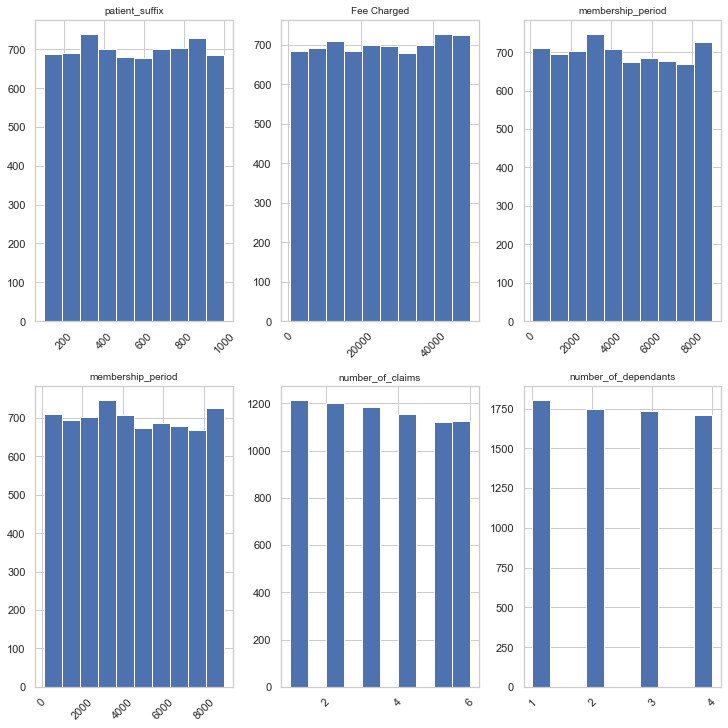

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(10,10), constrained_layout=True)
for i in range(2):
    for j in range(3):
        if 2*i + j < len(num_features):
            df[num_features[2*i + j]].hist(bins=10, ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].set_title(num_features[2*i + j],size=10)

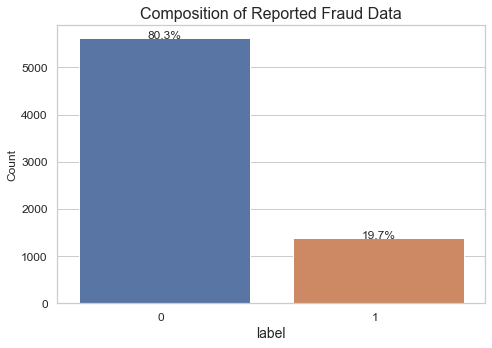

In [22]:
plt.figure(figsize =(7,5))
ax = sns.countplot(data = df, x = 'label')
plt.xticks(size = 12)
plt.xlabel('label', size = 14)
plt.yticks(size = 12)
plt.ylabel('Count', size = 12)
plt.title("Composition of Reported Fraud Data", size = 16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.tight_layout()
plt.show()

# Pre-Pipeline
- Define feature & label
- Split the data
- Define categorical & numerical feature
- Define encoder and scaler for preprocessing in the pipeline

In [19]:
df =df.drop(['email'], axis=1)

label = df['label']
data = df.drop(['label'], axis=1)
feature_names = data.columns

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data,label, train_size=0.8, random_state=1)

In [21]:
x_train

,member_name,gender,location,employer,relationship,patient_name,patient_suffix,patient_dob,cause,Fee Charged,membership_period,number_of_claims,number_of_dependants
4815,Konde,female,Rusape,Dabvine,Mother,Sithole,194,10/12/1975,Road Traffic Accident,11100,8166,3,4
3059,Evans,male,Bindura,Dabtype,Sister,Chisa,618,5/10/1986,Accident At Home,36819,5327,3,1
985,Bima,female,Gwanda,Chatterpoint,Mother,Gura,868,9/23/1985,Accident At Work,15495,1131,5,4
6022,Mirwa,female,Nyanga,Jabbertype,Uncle,Mabhena,321,11/26/1984,Other,25645,6341,6,2
6630,Sibanda,female,Kwekwe,Zoomzone,Wife,Bima,225,10/27/1967,Road Traffic Accident,46128,7536,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Dihwa,female,Mutare,Zoomdog,Wife,Sithole,682,1/23/1986,Other,42199,6138,5,4
5192,Moyo,female,Bindura,Brainlounge,Brother,Samvura,479,8/23/1971,Accident At Home,42453,376,4,2
3980,Samvura,male,Kadoma,Kazio,Sister,Nyoni,318,10/8/2007,Accident At Home,22514,3912,2,4
235,Gute,female,Marondera,Oodoo,Father,Bima,128,9/15/1971,Accident At Home,33672,6673,4,1


In [22]:
y_train

4815    0
3059    0
985     0
6022    0
6630    0
       ..
905     0
5192    0
3980    0
235     1
5157    0
Name: label, Length: 5600, dtype: int64

In [23]:
# Define preprocessor for one-hot encoding and min-max scaling
cat_col = ['member_name','gender','location','employer','relationship','patient_name','patient_dob','cause']
num_col = ['patient_suffix','Fee Charged','membership_period','number_of_claims','number_of_dependants']

### Transformers for numerical data
numerical_transformer = Pipeline(steps=[('Scaler', MinMaxScaler())])

### Transformers for categorical data
categorical_transformer = Pipeline(steps=[('Encoder', OneHotEncoder(handle_unknown='ignore'))])

### Combine pipelines using ColumnTransformer
preprocessing = ColumnTransformer(transformers=[('Numerical', numerical_transformer, num_col),
                                                ('Categorical', categorical_transformer, cat_col)],
                                  remainder='passthrough')

# PIPELINE
- Decision Tree
- Random Forest
- XGBoost
- Approximating XGBoost

## DECISION TREE

###Model

In [24]:
param_dt = {'max_depth': np.arange(5, 10),
            'min_samples_leaf': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            'min_samples_split': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)}

# Create pipelines with SMOTE for each model (nested GridSearchCV)
dt_grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=param_dt, scoring='roc_auc', cv=5)

dt_pipeline = ImbPipeline([
    ('preprocessing', preprocessing),
    ('oversampling', SMOTE(random_state=1)),
    ('grid_search', dt_grid)
])

dt_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['patient_suffix',
                                                   'Fee Charged',
                                                   'membership_period',
                                                   'number_of_claims',
                                                   'number_of_dependants']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['member_name', 'gender',
                                                   '...
                                                   'patient_name',
                                                   'patient_dob', 'cause'])])),
                ('oversampling', SMOTE(random_state=1)),
                ('grid_search',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(criterion='entropy'),
                              param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                                          'min_samples_leaf': (50, 100, 150,
                                                               200, 250, 300,
                                                               350, 400, 450,
                                                               500),
                                          'min_samples_split': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500)},
                              scoring='roc_auc'))])

In [25]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = dt_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': 9, 'min_samples_leaf': 50, 'min_samples_split': 50}


In [26]:
pd.DataFrame(dt_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
400,0.187455,0.000003,0.000000,0.000000,9,50,50,"{'max_depth': 9, 'min_samples_leaf': 50, 'min_...",0.528258,0.807700,0.854867,0.841727,0.836227,0.773756,0.123712,1
401,0.181207,0.007653,0.003124,0.006248,9,50,100,"{'max_depth': 9, 'min_samples_leaf': 50, 'min_...",0.528258,0.807700,0.854867,0.841727,0.836227,0.773756,0.123712,1
421,0.165586,0.007651,0.000000,0.000000,9,150,100,"{'max_depth': 9, 'min_samples_leaf': 150, 'min...",0.516282,0.789945,0.864653,0.850375,0.847243,0.773700,0.131216,3
424,0.162462,0.007653,0.003123,0.006247,9,150,250,"{'max_depth': 9, 'min_samples_leaf': 150, 'min...",0.516282,0.789945,0.864653,0.850375,0.847243,0.773700,0.131216,3
423,0.162463,0.007653,0.003124,0.006247,9,150,200,"{'max_depth': 9, 'min_samples_leaf': 150, 'min...",0.516282,0.789945,0.864653,0.850375,0.847243,0.773700,0.131216,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.120964,0.006323,0.001197,0.001466,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.489660,0.691341,0.696901,0.695629,0.685979,0.651902,0.081211,493
16,0.112259,0.007778,0.003922,0.005917,5,100,350,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.489660,0.692508,0.696533,0.694990,0.685172,0.651773,0.081150,497
17,0.112021,0.006844,0.003723,0.006061,5,100,400,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.489660,0.692508,0.696533,0.694990,0.685172,0.651773,0.081150,497
18,0.116553,0.008890,0.002086,0.001139,5,100,450,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.489660,0.692508,0.696533,0.694990,0.685172,0.651773,0.081150,497


In [27]:
joblib.dump(dt_pipeline, 'model_dt7.h5')

['model_dt7.h5']

### Statistical Performances

In [28]:
train_dt = dt_pipeline.predict(x_test)
print(classification_report(y_test, train_dt))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1132
           1       0.20      0.26      0.23       268

    accuracy                           0.67      1400
   macro avg       0.51      0.51      0.51      1400
weighted avg       0.70      0.67      0.68      1400



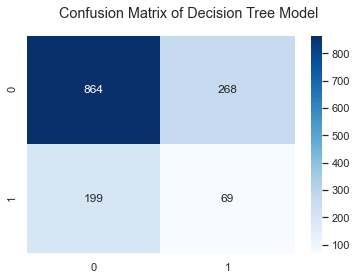

In [29]:
cm = confusion_matrix(y_test, train_dt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of Decision Tree Model")
plt.show()

In [30]:
# Calculate ROC AUC
probabilities = dt_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.5212080059068616
Specificity: 0.7632508833922261
Sensitivity: 0.2574626865671642


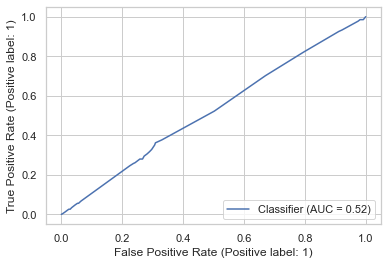

In [31]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [32]:
model_dt = DecisionTreeClassifier(criterion='entropy',**dt_pipeline.named_steps['grid_search'].best_params_)

dt_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_dt)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    dt_pipeline.fit(x_train, y_train)
    
    train_dt = dt_pipeline.predict(x_test)
    
    # Calculate ROC AUC
    probabilities = dt_pipeline.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)
    
    cm = confusion_matrix(y_test, train_dt)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 0.5212080059068616
Specificity = 0.7632508833922261
Sensitivity = 0.2574626865671642
 
iteration2
ROC_AUC = 0.5212080059068616
Specificity = 0.7632508833922261
Sensitivity = 0.2574626865671642
 
iteration3
ROC_AUC = 0.5212080059068616
Specificity = 0.7632508833922261
Sensitivity = 0.2574626865671642
 
iteration4
ROC_AUC = 0.5212080059068616
Specificity = 0.7632508833922261
Sensitivity = 0.2574626865671642
 
iteration5
ROC_AUC = 0.5212080059068616
Specificity = 0.7632508833922261
Sensitivity = 0.2574626865671642
 


## RANDOM FOREST

###Model

In [33]:
param_rf = {'max_depth': np.arange(5, 10),
            'min_samples_leaf': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            'min_samples_split': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)}

rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=250,
                                              criterion='entropy',
                                              n_jobs=-1),
                       param_grid=param_rf, scoring='roc_auc',cv=5)

rf_pipeline = ImbPipeline([
    ('preprocessing', preprocessing),
    ('oversampling', SMOTE(random_state=1)),
    ('grid_search', rf_grid)
])

rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['patient_suffix',
                                                   'Fee Charged',
                                                   'membership_period',
                                                   'number_of_claims',
                                                   'number_of_dependants']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['member_name', 'gender',
                                                   '...
                                                   'patient_dob', 'cause'])])),
                ('oversampling', SMOTE(random_state=1)),
                ('grid_search',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(criterion='entropy',
                                                               n_estimators=250,
                                                               n_jobs=-1),
                              param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                                          'min_samples_leaf': (50, 100, 150,
                                                               200, 250, 300,
                                                               350, 400, 450,
                                                               500),
                                          'min_samples_split': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500)},
                              scoring='roc_auc'))])

In [34]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = rf_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 50, 'min_samples_split': 50}


In [35]:
pd.DataFrame(rf_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
300,0.481002,0.011776,0.137551,0.042304,8,50,50,"{'max_depth': 8, 'min_samples_leaf': 50, 'min_...",0.553721,0.830648,0.921676,0.915710,0.913256,0.827002,0.140689,1
303,0.493630,0.007659,0.168717,0.015315,8,50,200,"{'max_depth': 8, 'min_samples_leaf': 50, 'min_...",0.550615,0.820930,0.922762,0.921493,0.904983,0.824156,0.141821,2
306,0.484248,0.009885,0.146855,0.040076,8,50,350,"{'max_depth': 8, 'min_samples_leaf': 50, 'min_...",0.548372,0.825110,0.911363,0.905438,0.915952,0.821247,0.140466,3
301,0.478002,0.007797,0.115680,0.046803,8,50,100,"{'max_depth': 8, 'min_samples_leaf': 50, 'min_...",0.545491,0.815358,0.911580,0.915327,0.913687,0.820288,0.142568,4
102,0.489110,0.007657,0.158315,0.021808,6,50,150,"{'max_depth': 6, 'min_samples_leaf': 50, 'min_...",0.558309,0.820379,0.915821,0.920002,0.886065,0.820115,0.135668,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.618674,0.117969,0.156215,0.053168,7,500,450,"{'max_depth': 7, 'min_samples_leaf': 500, 'min...",0.495155,0.644367,0.691236,0.704729,0.628518,0.632801,0.074413,496
94,0.881105,0.064534,0.196768,0.012460,5,500,250,"{'max_depth': 5, 'min_samples_leaf': 500, 'min...",0.494256,0.642140,0.678070,0.670371,0.670316,0.631031,0.069476,497
495,0.865426,0.103906,0.209325,0.007506,9,500,300,"{'max_depth': 9, 'min_samples_leaf': 500, 'min...",0.485721,0.627748,0.671343,0.707710,0.657818,0.630068,0.076608,498
297,0.840507,0.037380,0.206054,0.006320,7,500,400,"{'max_depth': 7, 'min_samples_leaf': 500, 'min...",0.502243,0.629904,0.660855,0.668915,0.675511,0.627486,0.064541,499


In [36]:
joblib.dump(rf_pipeline, 'model_rf7.h5')

['model_rf7.h5']

### Statistical Performances

In [37]:
train_rf = rf_pipeline.predict(x_test)
print(classification_report(y_test, train_rf))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1132
           1       0.16      0.21      0.19       268

    accuracy                           0.64      1400
   macro avg       0.48      0.48      0.48      1400
weighted avg       0.68      0.64      0.66      1400



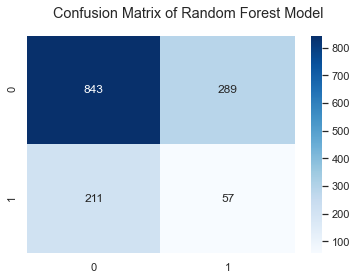

In [38]:
cm = confusion_matrix(y_test, train_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of Random Forest Model")
plt.show()

In [39]:
# Calculate ROC AUC
probabilities = rf_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.45987817098254313
Specificity: 0.7446996466431095
Sensitivity: 0.2126865671641791


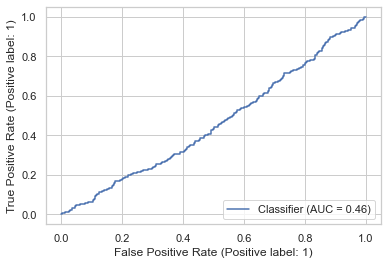

In [40]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [41]:
model_rf = RandomForestClassifier(n_estimators=250, criterion='entropy',
                                  **rf_pipeline.named_steps['grid_search'].best_params_)

rf_pipelines = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_rf)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    rf_pipelines.fit(x_train, y_train)
    
    train_rf = rf_pipelines.predict(x_test)
    
    # Calculate ROC AUC
    probabilities = rf_pipelines.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)
    
    cm = confusion_matrix(y_test, train_rf)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 0.48997283898528565
Specificity = 0.7455830388692579
Sensitivity = 0.25
 
iteration2
ROC_AUC = 0.48366054005590425
Specificity = 0.7438162544169611
Sensitivity = 0.22014925373134328
 
iteration3
ROC_AUC = 0.48129383998734243
Specificity = 0.7561837455830389
Sensitivity = 0.23507462686567165
 
iteration4
ROC_AUC = 0.4812246189546965
Specificity = 0.7508833922261484
Sensitivity = 0.208955223880597
 
iteration5
ROC_AUC = 0.4966905753915933
Specificity = 0.7659010600706714
Sensitivity = 0.2126865671641791
 


## XGBOOST

###Model

In [42]:
param_xgb_main = {'max_depth': np.arange(5, 10),
                  'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                  'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
                  'n_estimators': [100, 200, 300, 400, 500],
                  'lambda': np.arange(0, 10),
                  'gamma': np.arange(0, 10),
                  'colsample_bytree':np.arange(0.5, 1),
                  'min_child_weight':np.arange(4, 10)}

In [43]:
param_xgb = {'max_depth': np.arange(5, 10),
             'eta': [0.01, 0.05, 0.10, 0.15, 0.20],
             'gamma': np.arange(0, 10),
             'lambda': np.arange(0, 10)}

xgb_grid = GridSearchCV(XGBClassifier(n_estimators=250,
                                      subsample=0.8,
                                      objective='binary:logistic',
                                      eval_metric='logloss'),
                        param_grid=param_xgb, cv=5, scoring ='roc_auc', n_jobs=-1)

xgb_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('grid_search', xgb_grid)])

xgb_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['patient_suffix',
                                                   'Fee Charged',
                                                   'membership_period',
                                                   'number_of_claims',
                                                   'number_of_dependants']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['member_name', 'gender',
                                                   '...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=250,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                                          'gamma': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'lambda': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'max_depth': array([5, 6, 7, 8, 9])},
                              scoring='roc_auc'))])

In [44]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = xgb_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'eta': 0.2, 'gamma': 0, 'lambda': 9, 'max_depth': 9}


In [45]:
pd.DataFrame(xgb_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_gamma,param_lambda,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2049,24.541106,3.680804,0.062485,0.009879,0.2,0,9,9,"{'eta': 0.2, 'gamma': 0, 'lambda': 9, 'max_dep...",0.561678,0.892561,0.999945,0.999911,0.999885,0.890796,0.169730,1
1049,22.119800,2.845588,0.059363,0.006248,0.1,0,9,9,"{'eta': 0.1, 'gamma': 0, 'lambda': 9, 'max_dep...",0.562818,0.889931,0.999996,0.999985,0.999998,0.890546,0.169317,2
2048,19.561026,2.454198,0.053115,0.007652,0.2,0,9,8,"{'eta': 0.2, 'gamma': 0, 'lambda': 9, 'max_dep...",0.560478,0.892117,0.999993,0.999953,0.999971,0.890503,0.170217,3
544,16.533618,1.850256,0.049988,0.006247,0.05,0,8,9,"{'eta': 0.05, 'gamma': 0, 'lambda': 8, 'max_de...",0.561965,0.890116,0.999980,0.999999,1.000000,0.890412,0.169647,4
1039,21.613671,2.849042,0.056237,0.007653,0.1,0,7,9,"{'eta': 0.1, 'gamma': 0, 'lambda': 7, 'max_dep...",0.560527,0.891204,1.000000,0.999978,0.999998,0.890341,0.170205,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4.620789,0.503424,0.024995,0.007653,0.01,2,9,5,"{'eta': 0.01, 'gamma': 2, 'lambda': 9, 'max_de...",0.506404,0.875046,0.996664,0.999601,0.999697,0.875482,0.190651,2496
395,4.536432,0.557278,0.024994,0.007653,0.01,7,9,5,"{'eta': 0.01, 'gamma': 7, 'lambda': 9, 'max_de...",0.506404,0.875097,0.996886,0.999281,0.999698,0.875473,0.190638,2497
295,4.552677,0.523658,0.031243,0.000002,0.01,5,9,5,"{'eta': 0.01, 'gamma': 5, 'lambda': 9, 'max_de...",0.506404,0.875198,0.996727,0.999317,0.999698,0.875469,0.190622,2498
345,4.552055,0.557014,0.028119,0.006249,0.01,6,9,5,"{'eta': 0.01, 'gamma': 6, 'lambda': 9, 'max_de...",0.506404,0.875156,0.996694,0.999290,0.999683,0.875445,0.190612,2499


In [46]:
joblib.dump(xgb_pipeline, 'model_xgb7.h5')

['model_xgb7.h5']

### Statistical Performances

In [47]:
train_xgb = xgb_pipeline.predict(x_test)
print(classification_report(y_test, train_xgb))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1132
           1       0.22      0.04      0.07       268

    accuracy                           0.79      1400
   macro avg       0.51      0.50      0.47      1400
weighted avg       0.70      0.79      0.73      1400



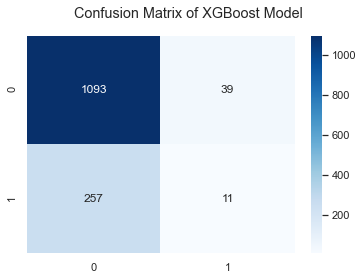

In [48]:
cm = confusion_matrix(y_test, train_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of XGBoost Model")
plt.show()

In [49]:
# Calculate ROC AUC
probabilities = xgb_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.4974948578661462
Specificity: 0.965547703180212
Sensitivity: 0.041044776119402986


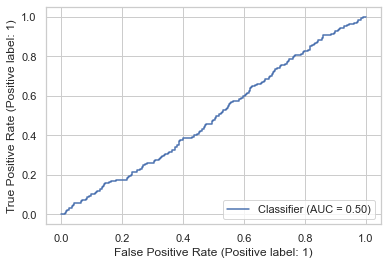

In [50]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [51]:
model_xgb = XGBClassifier(n_estimators=250,
                          subsample=0.8,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          **xgb_pipeline.named_steps['grid_search'].best_params_)

In [26]:
model_xgb = XGBClassifier(n_estimators=250,
                          subsample=0.8,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          eta=0.2, gamma=0, reg_lambda=9, max_dept=9)

In [27]:
xgb_pipelines = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_xgb)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    xgb_pipelines.fit(x_train, y_train)
    
    train_xgb = xgb_pipelines.predict(x_test)
    
    # Calculate ROC AUC
    probabilities = xgb_pipelines.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)
    
    cm = confusion_matrix(y_test, train_xgb)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


iteration1
ROC_AUC = 0.5170184853119562
Specificity = 0.9699646643109541
Sensitivity = 0.03731343283582089
 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


iteration2
ROC_AUC = 0.5170184853119562
Specificity = 0.9699646643109541
Sensitivity = 0.03731343283582089
 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


iteration3
ROC_AUC = 0.5170184853119562
Specificity = 0.9699646643109541
Sensitivity = 0.03731343283582089
 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


iteration4
ROC_AUC = 0.5170184853119562
Specificity = 0.9699646643109541
Sensitivity = 0.03731343283582089
 


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


iteration5
ROC_AUC = 0.5170184853119562
Specificity = 0.9699646643109541
Sensitivity = 0.03731343283582089
 


## APPROXIMATING XGBOOST

###Pre-Modeling

In [28]:
#one-hot encode categorical data
encoder = OneHotEncoder(sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(data[cat_col]))
df_encoded.columns = encoder.get_feature_names_out(cat_col)

#scale numerical data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[num_col])
df_scaled = pd.DataFrame(scaled_data, columns=num_col)

df_preprocessed = pd.concat([df_encoded, df_scaled], axis=1)
df_preprocessed

,member_name_Bima,member_name_Chipi,member_name_Chiri,member_name_Chisa,member_name_Chisa Chisi,member_name_Dihwa,member_name_Evans,member_name_Femba,member_name_Foto,member_name_Geta,...,patient_dob_9/9/2009,cause_Accident At Home,cause_Accident At Work,cause_Other,cause_Road Traffic Accident,patient_suffix,Fee Charged,membership_period,number_of_claims,number_of_dependants
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.766407,0.066572,0.161910,0.2,1.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.845384,0.977917,0.917865,0.6,0.666667
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.304783,0.797252,0.687978,0.2,0.333333
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.699666,0.695929,0.981124,1.0,0.666667
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.685206,0.939105,0.977978,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.550612,0.501162,0.716629,0.6,0.666667
6996,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.064516,0.654450,0.037978,0.0,0.000000
6997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.715239,0.375371,0.902697,0.4,0.000000
6998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.413793,0.630650,0.920562,0.6,0.666667


In [29]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_preprocessed, label, train_size=0.8, random_state=1)

In [30]:
# Create SMOTE object
smote = SMOTE(random_state=1)

# Transform data
x_smote, y_smote = smote.fit_resample(x_train2, y_train2)

In [31]:
x_smote

,member_name_Bima,member_name_Chipi,member_name_Chiri,member_name_Chisa,member_name_Chisa Chisi,member_name_Dihwa,member_name_Evans,member_name_Femba,member_name_Foto,member_name_Geta,...,patient_dob_9/9/2009,cause_Accident At Home,cause_Accident At Work,cause_Other,cause_Road Traffic Accident,patient_suffix,Fee Charged,membership_period,number_of_claims,number_of_dependants
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.104561,0.214102,0.906292,0.400000,1.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.576196,0.733731,0.587303,0.400000,0.000000
2,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.854283,0.302899,0.115843,0.800000,1.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.245829,0.507971,0.701236,1.000000,0.333333
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.139043,0.921810,0.835506,0.600000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8973,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.414309,0.255663,0.048548,0.396293,0.339511
8974,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.313170,0.344022,0.533890,0.062374,1.000000
8975,0.000000,0.0,0.0,0.019423,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.468462,0.932823,0.066969,0.392231,0.000000
8976,0.544728,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.440281,0.324511,0.414126,0.564218,0.333333


In [32]:
x_smote.columns = [str(col) for col in x_smote.columns]
x_smote

,member_name_Bima,member_name_Chipi,member_name_Chiri,member_name_Chisa,member_name_Chisa Chisi,member_name_Dihwa,member_name_Evans,member_name_Femba,member_name_Foto,member_name_Geta,...,patient_dob_9/9/2009,cause_Accident At Home,cause_Accident At Work,cause_Other,cause_Road Traffic Accident,patient_suffix,Fee Charged,membership_period,number_of_claims,number_of_dependants
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.104561,0.214102,0.906292,0.400000,1.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.576196,0.733731,0.587303,0.400000,0.000000
2,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.854283,0.302899,0.115843,0.800000,1.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.245829,0.507971,0.701236,1.000000,0.333333
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.139043,0.921810,0.835506,0.600000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8973,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.414309,0.255663,0.048548,0.396293,0.339511
8974,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.313170,0.344022,0.533890,0.062374,1.000000
8975,0.000000,0.0,0.0,0.019423,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.468462,0.932823,0.066969,0.392231,0.000000
8976,0.544728,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.440281,0.324511,0.414126,0.564218,0.333333


In [33]:
x_smote.columns

Index(['member_name_Bima', 'member_name_Chipi', 'member_name_Chiri',
       'member_name_Chisa', 'member_name_Chisa Chisi', 'member_name_Dihwa',
       'member_name_Evans', 'member_name_Femba', 'member_name_Foto',
       'member_name_Geta',
       ...
       'patient_dob_9/9/2009', 'cause_Accident At Home',
       'cause_Accident At Work', 'cause_Other', 'cause_Road Traffic Accident',
       'patient_suffix', 'Fee Charged', 'membership_period',
       'number_of_claims', 'number_of_dependants'],
      dtype='object', length=6129)

In [34]:
y_smote = y_smote.to_frame()
y_smote

,label
0,0
1,0
2,0
3,0
4,0
...,...
8973,1
8974,1
8975,1
8976,1


In [35]:
x_test2

,member_name_Bima,member_name_Chipi,member_name_Chiri,member_name_Chisa,member_name_Chisa Chisi,member_name_Dihwa,member_name_Evans,member_name_Femba,member_name_Foto,member_name_Geta,...,patient_dob_9/9/2009,cause_Accident At Home,cause_Accident At Work,cause_Other,cause_Road Traffic Accident,patient_suffix,Fee Charged,membership_period,number_of_claims,number_of_dependants
2305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.022247,0.011617,0.148427,0.2,0.666667
4388,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.787542,0.136559,0.281910,0.8,0.333333
1686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.558398,0.630650,0.798989,0.0,1.000000
4945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.570634,0.349328,0.625618,1.0,0.333333
4197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.022247,0.936761,0.338427,0.8,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.827586,0.812466,0.852135,0.0,1.000000
997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.718576,0.191716,0.164494,1.0,0.666667
4672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.477197,0.803617,0.671011,0.2,0.000000
3152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.312570,0.009092,0.093146,0.0,0.000000


In [36]:
y_test2=y_test2.to_frame()
y_test2

,label
2305,0
4388,0
1686,1
4945,0
4197,0
...,...
2090,0
997,0
4672,0
3152,0


###Model

In [37]:
model_xgb.fit(x_smote, y_smote)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_dept=9,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=250, n_jobs=None, ...)

In [38]:
#Get Features & Label Name
feature_cols = list(x_smote.columns)
label_name = y_smote.columns[0]

#Combine x_train & y_train
df_train = x_smote.copy()
df_train[label_name] = y_smote.values.squeeze()

#Use The Method
model_apprx_xgb = FBT(max_depth=10, max_number_of_conjunctions=5000, min_forest_size=150, pruning_method='auc')

#Fit Model
model_apprx_xgb.fit(df_train, feature_cols, label_name, model_xgb)

Start pruning
Pruned forest training set AUC: 0.9982378027505269
Create conjunction set from training data instances
Number of conjunctions created from data: 8916
Create complete conjunction set
Size at iteration 2: 773
Size at iteration 3: 5001
Size at iteration 4: 5001
Size at iteration 5: 5001
Size at iteration 6: 5001
Size at iteration 7: 5001
Size at iteration 8: 5001
Size at iteration 9: 5001
Size at iteration 10: 5001
Size at iteration 11: 5001
Size at iteration 12: 5001
Size at iteration 13: 5001
Size at iteration 14: 5001
Size at iteration 15: 5001
Size at iteration 16: 5001
Size at iteration 17: 5001
Size at iteration 18: 5001
Size at iteration 19: 5001
Size at iteration 20: 5001
Size at iteration 21: 5001
Size at iteration 22: 5001
Size at iteration 23: 5001
Size at iteration 24: 5001
Size at iteration 25: 5001
Size at iteration 26: 5001
Size at iteration 27: 5001
Size at iteration 28: 5001
Size at iteration 29: 5001
Size at iteration 30: 5001
Size at iteration 31: 5001
Siz

In [39]:
joblib.dump(model_apprx_xgb, 'model_apprx_xgb7.h5')

['model_apprx_xgb7.h5']

### Statistical Performances

In [40]:
train_apprx_xgb = model_apprx_xgb.predict(x_test2)
print(classification_report(y_test, train_apprx_xgb))

              precision    recall  f1-score   support

           0       0.80      0.32      0.46      1132
           1       0.19      0.66      0.29       268

    accuracy                           0.38      1400
   macro avg       0.49      0.49      0.37      1400
weighted avg       0.68      0.38      0.42      1400



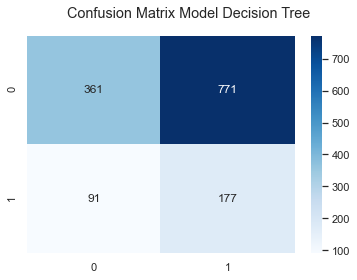

In [41]:
cm = confusion_matrix(y_test2, train_apprx_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix Model Decision Tree")
plt.show()

In [42]:
# Calculate ROC AUC
probabilities = model_apprx_xgb.predict_proba(x_test2)[:, 1]
roc_auc = roc_auc_score(y_test2, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.47918424661146564
Specificity: 0.31890459363957596
Sensitivity: 0.6604477611940298


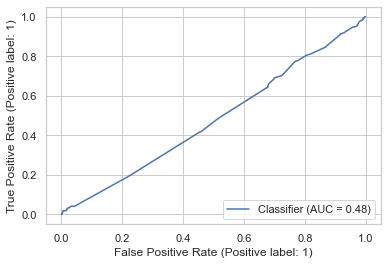

In [43]:
RocCurveDisplay.from_predictions(y_test2, probabilities, pos_label=1)
plt.show()

In [ ]:
roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    model_apprx_xgb.fit(df_train, feature_cols, label_name, model_xgb)
    
    train_apprx_xgb = model_apprx_xgb.predict(x_test2)
    
    # Calculate ROC AUC
    probabilities = model_apprx_xgb.predict_proba(x_test2)[:, 1]
    roc_auc = roc_auc_score(y_test2, probabilities)
    
    cm = confusion_matrix(y_test2, train_apprx_xgb)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print(f"iteration{i+1}")
    print(f"ROC_AUC={roc_auc}")
    print(f"Specificity={specificity}")
    print(f"Sensitivity={sensitivity}")
    print(" ")

# Interpretasi Model

## Feature Importance

Text(0.5, 0, 'Decrease in Accuracy Score')

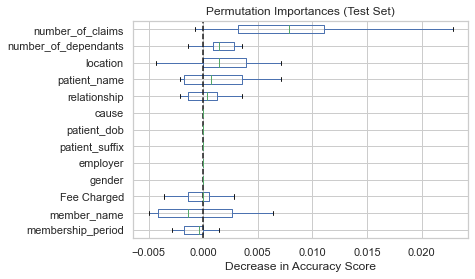

In [31]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(dt_pipeline, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_dt = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_dt[0:14]].T,
                           columns=feature_names[sorted_importances_idx_dt[0:14]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")

Text(0.5, 0, 'Decrease in Accuracy Score')

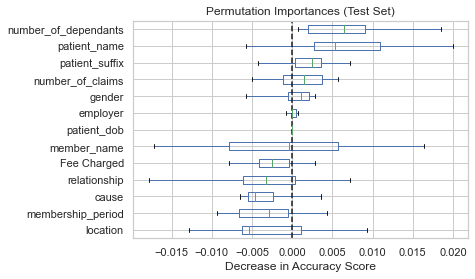

In [33]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_pipelines, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_rf = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_rf[0:14]].T,
                           columns=feature_names[sorted_importances_idx_rf[0:14]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")

Text(0.5, 0, 'Decrease in Accuracy Score')

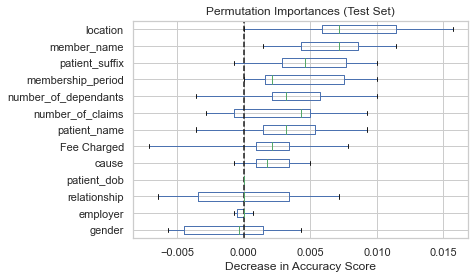

In [34]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)i
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_pipelines, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_xgb = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_xgb[0:14]].T,
                           columns=feature_names[sorted_importances_idx_xgb[0:14]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, accuracy_score

scorer = make_scorer(accuracy_score)

result = permutation_importance(model_apprx_xgb, x_test2, y_test2, n_repeats=10, random_state=1, scoring = scorer)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx[0:14]].T,
                           columns=feature_names[sorted_importances_idx[0:14]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")

## PDPs

In [35]:
numerical_features_sorted_dt = [feature_names[i] for i in sorted_importances_idx_dt if feature_names[i] in num_col]
numerical_features_sorted_dt.reverse()

numerical_features_sorted_rf = [feature_names[i] for i in sorted_importances_idx_rf if feature_names[i] in num_col]
numerical_features_sorted_rf.reverse()

numerical_features_sorted_xgb = [feature_names[i] for i in sorted_importances_idx_xgb if feature_names[i] in num_col]
numerical_features_sorted_xgb.reverse()

# numerical_features_sorted = [feature_names[i] for i in sorted_importances_idx_dt if feature_names[i] in num_col]
# numerical_features_sorted.reverse()

print(numerical_features_sorted_dt)
print(numerical_features_sorted_rf)
print(numerical_features_sorted_xgb)

['number_of_claims', 'number_of_dependants', 'patient_suffix', 'Fee Charged', 'membership_period']
['number_of_dependants', 'patient_suffix', 'number_of_claims', 'Fee Charged', 'membership_period']
['patient_suffix', 'membership_period', 'number_of_dependants', 'number_of_claims', 'Fee Charged']


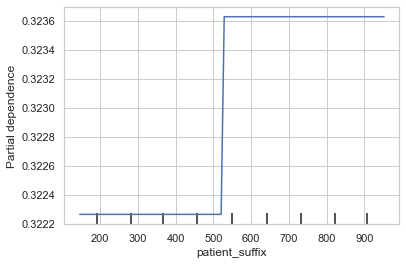

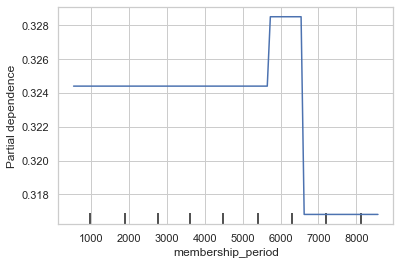

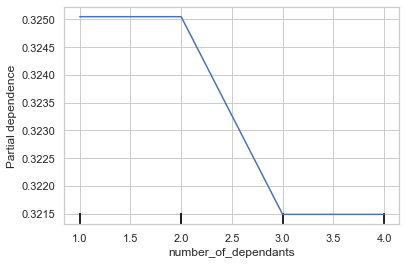

In [36]:
PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

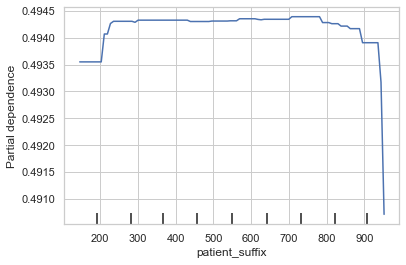

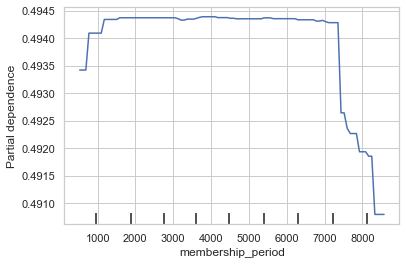

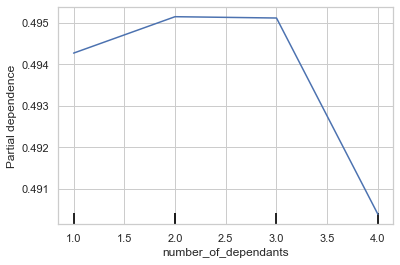

In [38]:
PartialDependenceDisplay.from_estimator(rf_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(rf_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(rf_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

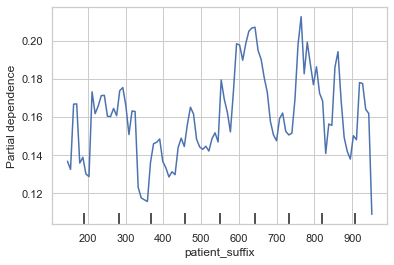

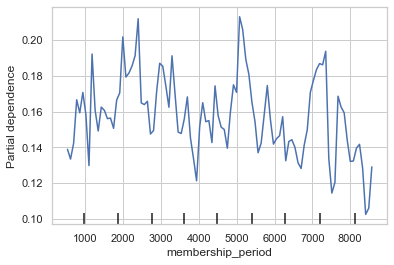

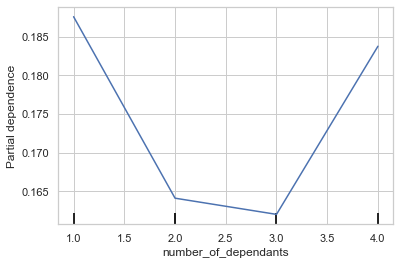

In [39]:
PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

##ICEs

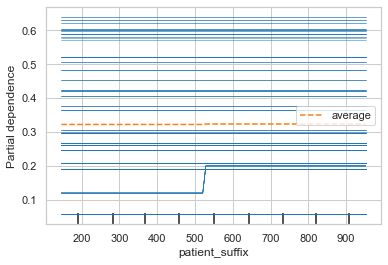

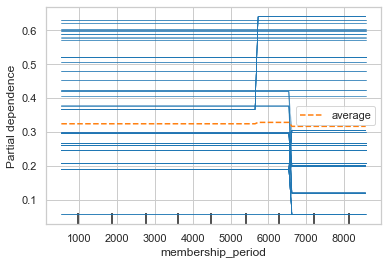

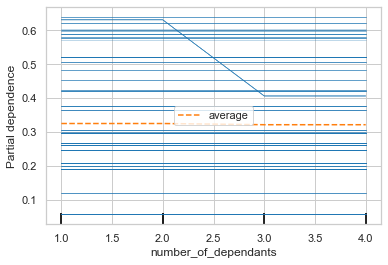

In [40]:
PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

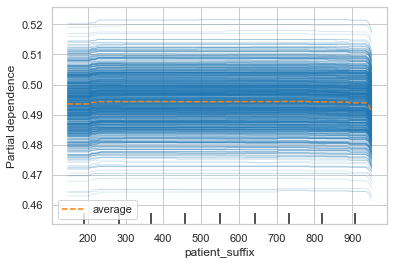

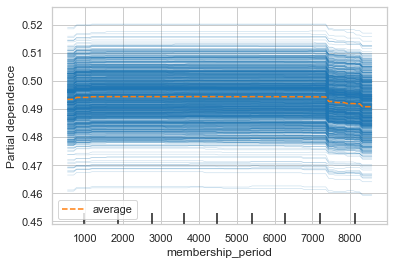

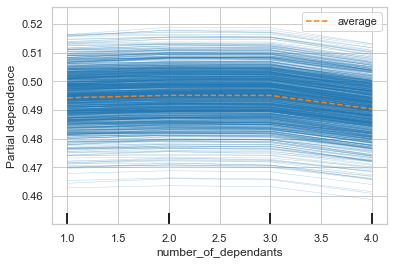

In [41]:
PartialDependenceDisplay.from_estimator(rf_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(rf_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(rf_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

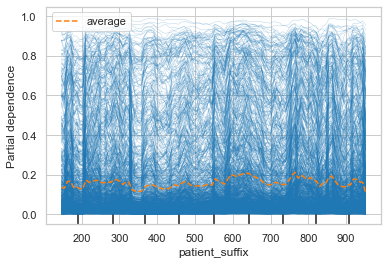

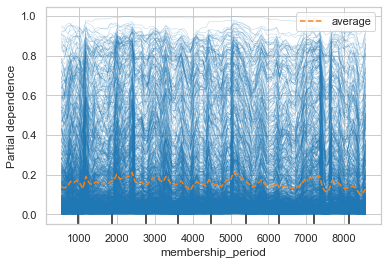

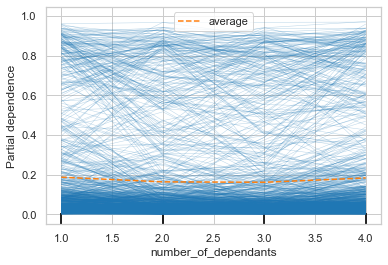

In [42]:
PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

# Inside The Model

## Model Decision Tree

In [45]:
model_dt = DecisionTreeClassifier(criterion='entropy',max_depth=9, min_samples_leaf=50,min_samples_split=50)

In [46]:
# Show The Rule from Model

model_dt.fit(x_smote, y_smote)

rule = export_text(model_dt)
print(rule)

|--- feature_6127 <= 0.00
|   |--- feature_26 <= 0.09
|   |   |--- feature_436 <= 0.00
|   |   |   |--- feature_447 <= 0.06
|   |   |   |   |--- feature_11 <= 0.03
|   |   |   |   |   |--- feature_6126 <= 0.73
|   |   |   |   |   |   |--- feature_35 <= 0.07
|   |   |   |   |   |   |   |--- feature_32 <= 0.15
|   |   |   |   |   |   |   |   |--- feature_6120 <= 0.09
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_6120 >  0.09
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_32 >  0.15
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_35 >  0.07
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_6126 >  0.73
|   |   |   |   |   |   |--- feature_6121 <= 0.50
|   |   |   |   |   |   |   |--- feature_6123 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_6124 <= 0.47
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   

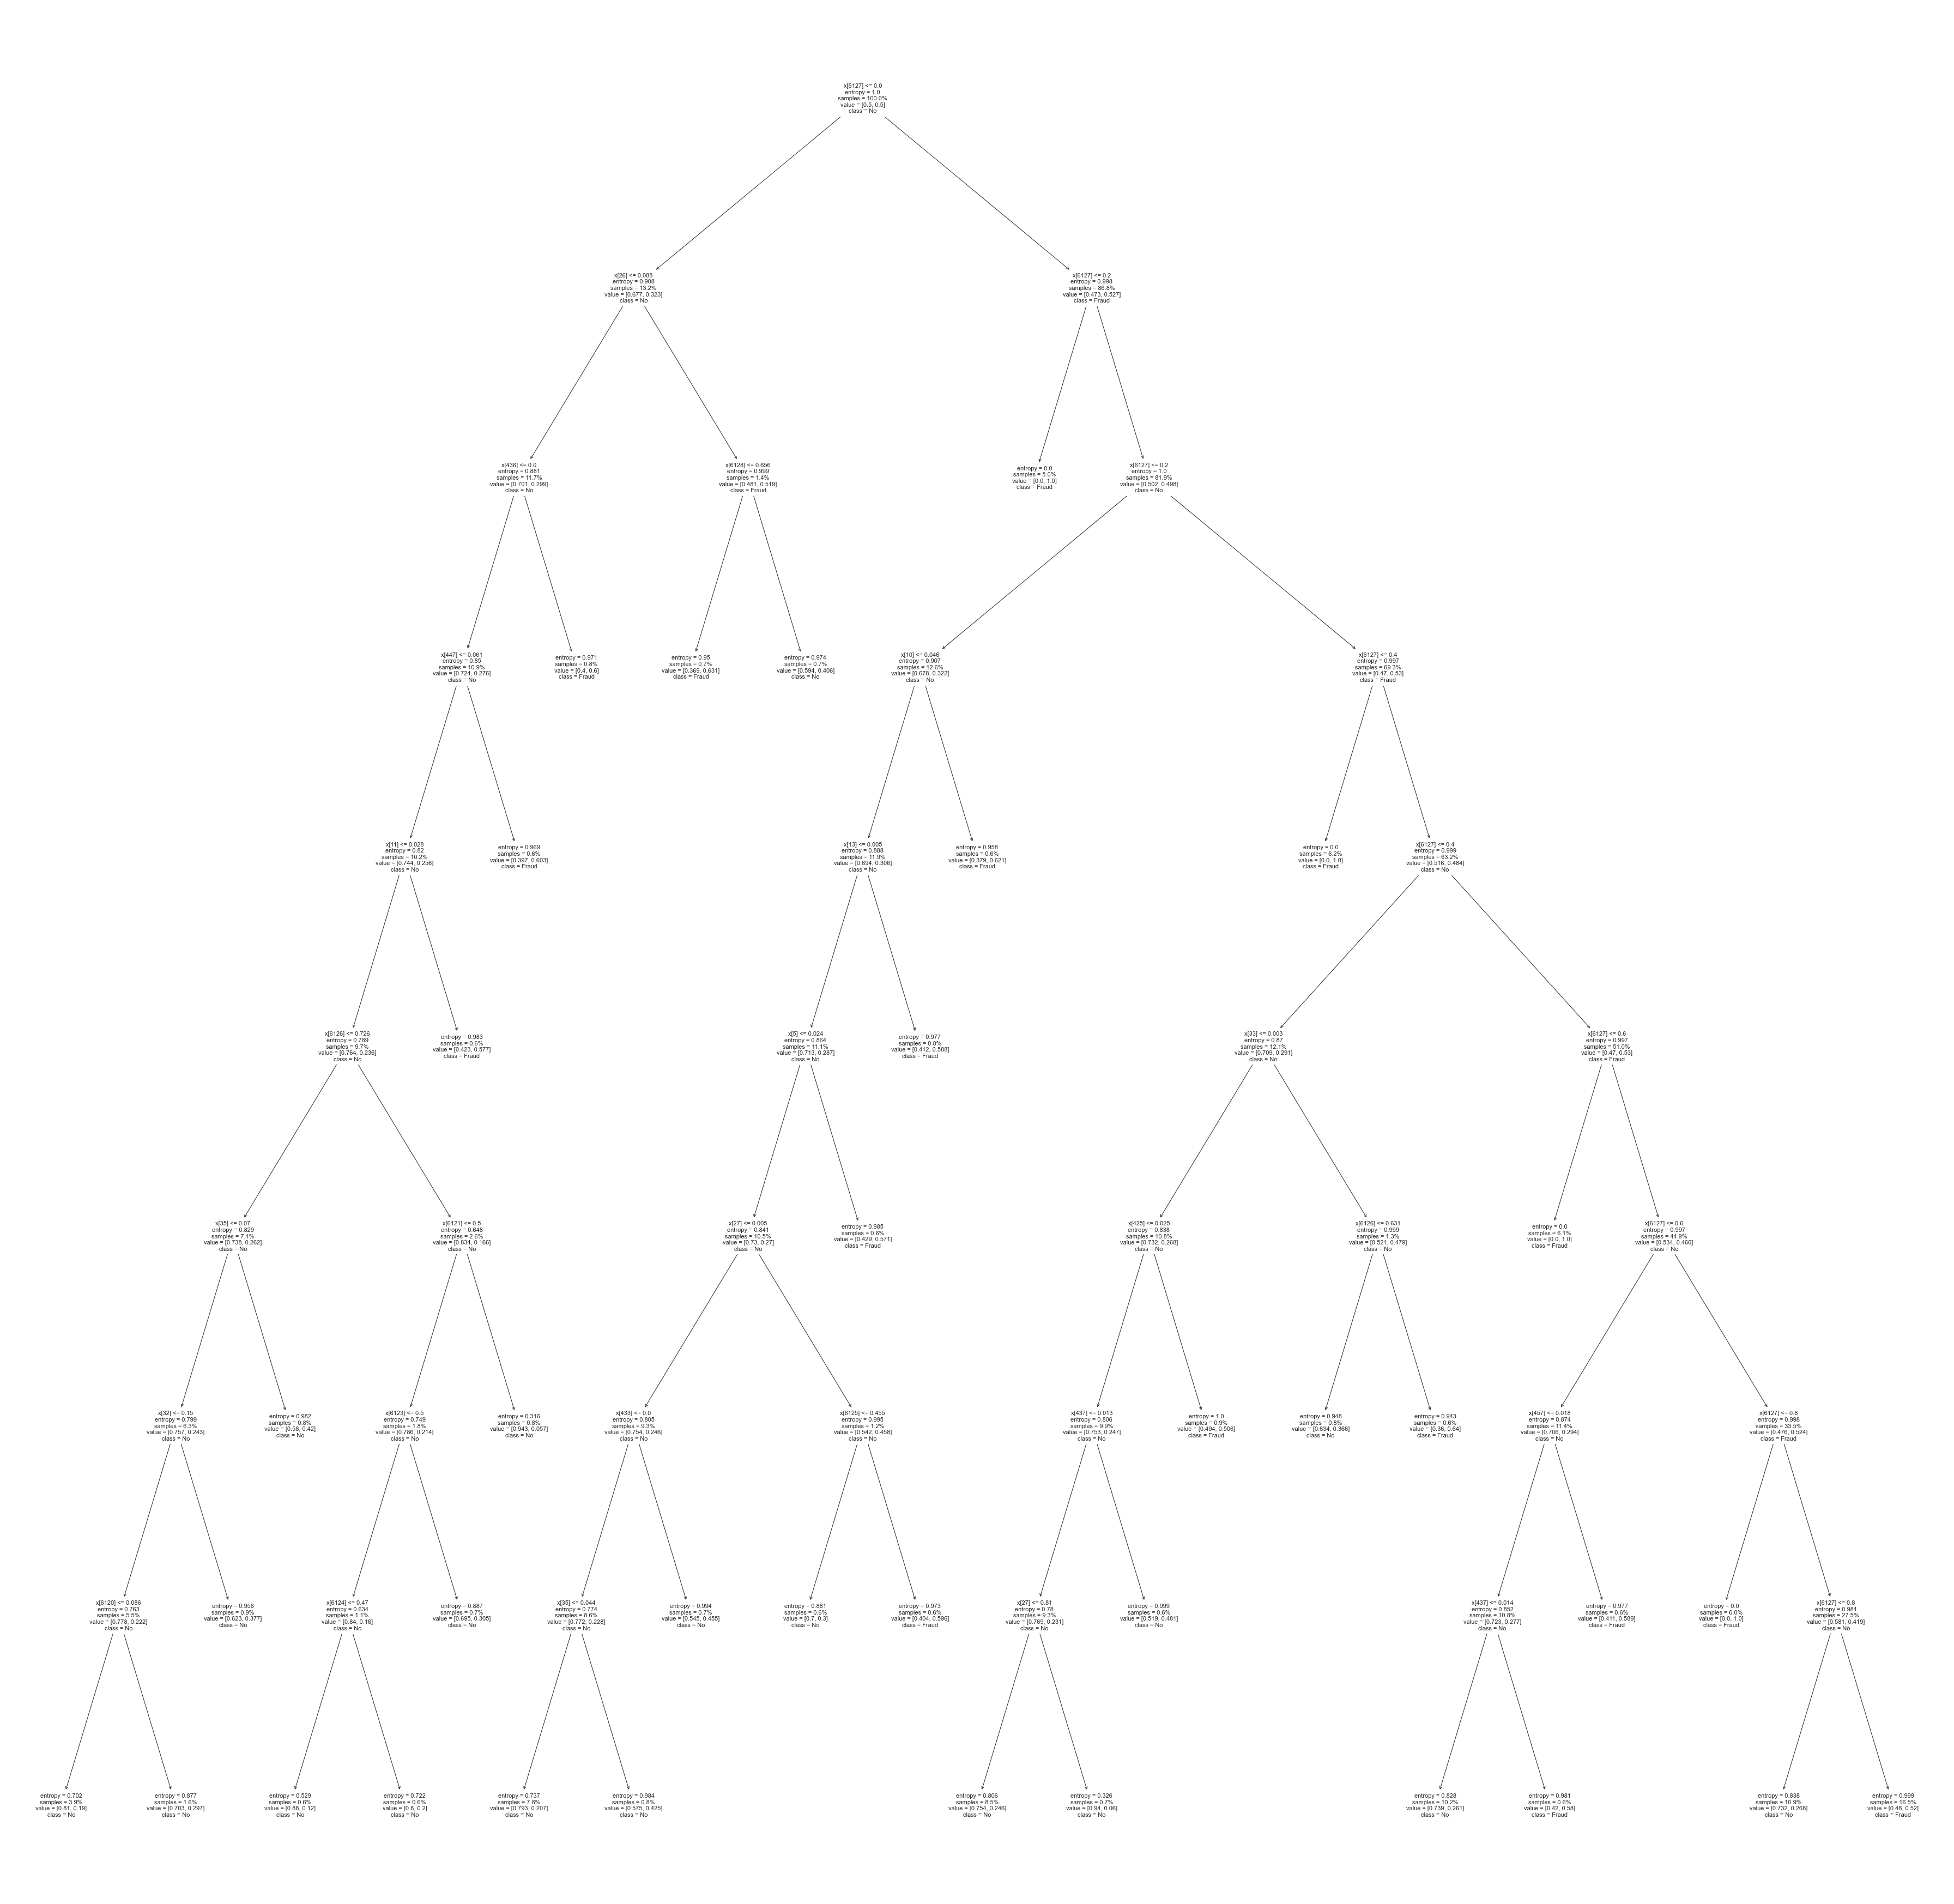

In [47]:
# Show The Tree of Model

plt.figure(figsize=(64,64))
plot_tree(model_dt, fontsize=11, proportion=True,class_names=['No', 'Fraud'])
plt.show()

## Model Approximating XGBoost

In [44]:
# Get The Rule from Model
model_apprx_xgb.tree.print_tree(feature_cols)

|--- gender_female >= 0.993761539
|   |--- gender_female >= 1.0
|   |   |--- number_of_dependants >= 1.0
|   |   |   |--- patient_suffix >= 0.596623003
|   |   |   |   |--- member_name_Chisa Chisi >= 0.00196364545
|   |   |   |   |   |--- member_name_Chisa Chisi >= 1.0
|   |   |   |   |   |   |--- relationship_Sister >= 0.0022376345
|   |   |   |   |   |   |   |--- location_Gweru >= 0.00200030068
|   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |--- location_Gweru < 0.00200030068
|   |   |   |   |   |   |   |   |--- location_Kadoma >= 0.000141330209
|   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- location_Kadoma < 0.000141330209
|   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |--- relationship_Sister < 0.0022376345
|   |   |   |   |   |   |   |--- location_Bulawayo >= 0.000398380042
|   |   |   |   |   |   |   |   |--- relationship_Father >= 0.0130126681
|   |   |   |   |   |   |   

|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- patient_suffix < 0.589543939
|   |   |   |   |   |   |   |   |   |--- patient_name_Sibanda >= 0.00149975682
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- patient_name_Sibanda < 0.00149975682
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |--- patient_suffix < 0.47608453
|   |   |   |   |   |--- patient_suffix >= 0.303670734
|   |   |   |   |   |   |--- Fee Charged >= 0.5648247
|   |   |   |   |   |   |   |--- patient_suffix >= 0.384872079
|   |   |   |   |   |   |   |   |--- cause_Road Traffic Accident >= 0.00355390087
|   |   |   |   |   |   |   |   |   |--- membership_period >= 0.581011236
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- membership_period < 0.581011236
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   

|   |   |   |   |   |   |   |   |--- Fee Charged >= 0.376974165
|   |   |   |   |   |   |   |   |   |--- number_of_claims >= 0.602333724
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- number_of_claims < 0.602333724
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- Fee Charged < 0.376974165
|   |   |   |   |   |   |   |   |   |--- number_of_claims >= 0.602333724
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- number_of_claims < 0.602333724
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |--- number_of_claims < 0.400001258
|   |   |   |   |   |   |   |   |--- number_of_dependants >= 0.333797455
|   |   |   |   |   |   |   |   |   |--- Fee Charged >= 0.376974165
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- Fee Charged < 0.376974165
|   |   |   |   

|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- membership_period < 0.265730351
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- number_of_claims < 0.602333724
|   |   |   |   |   |   |   |   |   |--- number_of_dependants >= 0.333797455
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- number_of_dependants < 0.333797455
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |--- Fee Charged < 0.434387326
|   |   |   |   |   |   |   |   |--- membership_period >= 0.265730351
|   |   |   |   |   |   |   |   |   |--- Fee Charged >= 0.279502988
|   |   |   |   |   |   |   |   |   |   |--- result:  82.99999999999999
|   |   |   |   |   |   |   |   |   |--- Fee Charged < 0.279502988
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- membership_period < 0.265730351
|   | 

|   |   |   |   |   |   |   |   |--- number_of_claims >= 0.218604594
|   |   |   |   |   |   |   |   |   |--- patient_suffix >= 0.394883215
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- patient_suffix < 0.394883215
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- number_of_claims < 0.218604594
|   |   |   |   |   |   |   |   |   |--- number_of_claims >= 0.202105433
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- number_of_claims < 0.202105433
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |--- gender_female < 0.891220629
|   |   |   |   |   |   |   |   |--- Fee Charged >= 0.434387326
|   |   |   |   |   |   |   |   |   |--- number_of_dependants >= 0.29517594
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- number_of_dependants < 0.29517594
|   | 

|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- membership_period < 0.294044942
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- number_of_claims < 0.400001258
|   |   |   |   |   |   |   |   |   |--- membership_period >= 0.294044942
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- membership_period < 0.294044942
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |--- Fee Charged < 0.619739354
|   |   |   |   |   |   |   |   |--- Fee Charged >= 0.473926663
|   |   |   |   |   |   |   |   |   |--- Fee Charged >= 0.5648247
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- Fee Charged < 0.5648247
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- Fee Charged < 0.473926663
|   |   |   |   |   |   |   |   |   |--- 

|   |   |   |   |   |   |--- cause_Accident At Work >= 1.0
|   |   |   |   |   |   |   |--- relationship_Wife >= 0.000977808144
|   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |--- relationship_Wife < 0.000977808144
|   |   |   |   |   |   |   |   |--- patient_suffix >= 0.0819549859
|   |   |   |   |   |   |   |   |   |--- patient_suffix >= 0.142380416
|   |   |   |   |   |   |   |   |   |   |--- result:  82.99999999999999
|   |   |   |   |   |   |   |   |   |--- patient_suffix < 0.142380416
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |--- patient_suffix < 0.0819549859
|   |   |   |   |   |   |   |   |   |--- patient_suffix >= 0.0467185751
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |   |   |   |--- patient_suffix < 0.0467185751
|   |   |   |   |   |   |   |   |   |   |--- result:  83.0
|   |   |   |   |   |   |--- cause_Accident At Work < 1.0
|   |   |   |   |   |   |  

In [ ]:
# Get the decision paths for the input data
paths = model_apprx_xgb.get_decision_paths(df)

# Print the decision paths
for i, path in enumerate(paths, start=1):
    print(f"Path {i}: {' -> '.join(path)}")

In [ ]:
extractNodesFromModel(model_xgb)

In [ ]:
model_apprx_xgb.set_ordered_splitting_points()